<a href="https://colab.research.google.com/github/PhamDucThinh1995/MNIST_GAN/blob/main/MNIST_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In practice, however, the minimax game would often lead to the network not converging, so it is important to carefully tune the training process. Hyperparameters such as learning rates are significantly more important in training a GAN — small changes may lead to GANs generating a single output regardless of the input noises

In [1]:
"""
Import necessary libraries to create a generative adversarial network
The code is mainly developed using the PyTorch library
"""
import time
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as VisionF
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms
from torchvision.utils import make_grid

In [2]:
"""
Network Architectures
The following are the discriminator and generator architectures
"""

class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 1)
        self.activation = nn.LeakyReLU(0.1)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return nn.Sigmoid()(x)


class generator(nn.Module):
    def __init__(self):
        super(generator, self).__init__()
        self.fc1 = nn.Linear(128, 1024)
        self.fc2 = nn.Linear(1024, 2048)
        self.fc3 = nn.Linear(2048, 784)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        x = x.view(-1, 1, 28, 28)
        return nn.Tanh()(x)

In [3]:
"""
Determine if any GPUs are available
"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
"""
Hyperparameter settings
"""
epochs = 150
lr = 2e-4
batch_size = 64
loss = nn.BCELoss()

In [5]:
# Model
G = generator().to(device)
D = discriminator().to(device)

G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

In [6]:
# for i in D.parameters():
#   print(i)

In [7]:
"""
Image transformation and dataloader creation
Note that we are training generation and not classification, and hence
only the train_loader is loaded
"""
# Transform
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Load data
train_set = datasets.MNIST('mnist/', train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



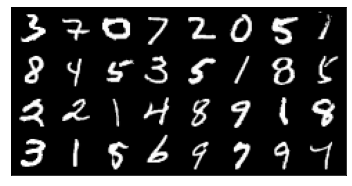

In [8]:
"""
Sketch train set for checking
"""
for x, labels in train_loader:
    img_grid = make_grid(x, normalize=True)

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = VisionF.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
show(img_grid)

In [9]:
x.shape

torch.Size([32, 1, 28, 28])

In [10]:
len(train_loader)

938

In [11]:
"""
Network training procedure
Every step both the loss for disciminator and generator is updated
Discriminator aims to classify reals and fakes
Generator aims to generate images as realistic as possible
Run idx to 1000
What is the function of "enumerate"? https://www.geeksforgeeks.org/enumerate-in-python/
"""
for epoch in tqdm(range(epochs)):
    for idx, (imgs, _) in enumerate(train_loader):
        # print('idxprevious: {}'.format(idx))
        idx += 1
        # print('idxafter: {}'.format(idx))
        # Training the discriminator
        # Real inputs are actual images of the MNIST dataset
        # Fake inputs are from the generator
        # Real inputs should be classified as 1 and fake as 0
        real_inputs = imgs.to(device)
        # print('realinputs')
        # print(real_inputs)
        real_outputs = D(real_inputs)
        # print('realoutputs')
        # print(real_outputs)
        real_label = torch.ones(real_inputs.shape[0], 1).to(device)
        # print('real_label')
        # print(real_label)

        noise = (torch.rand(real_inputs.shape[0], 128) - 0.5) / 0.5
        noise = noise.to(device)
        fake_inputs = G(noise)
        # print('fakeinputs')
        # print(fake_inputs)
        fake_outputs = D(fake_inputs)
        # print('fakeoutputs')
        # print(fake_outputs)
        fake_label = torch.zeros(fake_inputs.shape[0], 1).to(device)
        # print('fakelabel')
        # print(fake_label)

        outputs = torch.cat((real_outputs, fake_outputs), 0)
        targets = torch.cat((real_label, fake_label), 0)
        # print('real-fake-outputs')
        # print(outputs)
        # print('real-fake-targets')
        # print(targets)

        D_loss = loss(outputs, targets)   #Using BCE loss
        D_optimizer.zero_grad()
        D_loss.backward()
        D_optimizer.step()

        # Training the generator
        # For generator, goal is to make the discriminator believe everything is 1
        noise = (torch.rand(real_inputs.shape[0], 128)-0.5)/0.5
        noise = noise.to(device)

        fake_inputs = G(noise)
        fake_outputs = D(fake_inputs)
        fake_targets = torch.ones([fake_inputs.shape[0], 1]).to(device)
        G_loss = loss(fake_outputs, fake_targets)
        G_optimizer.zero_grad()
        G_loss.backward()
        G_optimizer.step()
        # print('Index: {}'.format(idx))
        if idx % 100 == 0 or idx == len(train_loader):
            print('Epoch {} Iteration {}: discriminator_loss {:.3f} generator_loss {:.3f}'.format(epoch, idx, D_loss.item(), G_loss.item()))

    if (epoch+1) % 10 == 0:
        torch.save(G, 'Generator_epoch_{}.pth'.format(epoch))
        print('Model saved.')

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 0 Iteration 100: discriminator_loss 0.629 generator_loss 1.020
Epoch 0 Iteration 200: discriminator_loss 0.693 generator_loss 0.724
Epoch 0 Iteration 300: discriminator_loss 0.625 generator_loss 0.807
Epoch 0 Iteration 400: discriminator_loss 0.598 generator_loss 0.853
Epoch 0 Iteration 500: discriminator_loss 0.578 generator_loss 0.861
Epoch 0 Iteration 600: discriminator_loss 0.543 generator_loss 0.844
Epoch 0 Iteration 700: discriminator_loss 0.613 generator_loss 0.823
Epoch 0 Iteration 800: discriminator_loss 0.485 generator_loss 0.920
Epoch 0 Iteration 900: discriminator_loss 0.534 generator_loss 0.940


  1%|          | 1/150 [00:14<35:17, 14.21s/it]

Epoch 0 Iteration 938: discriminator_loss 0.474 generator_loss 1.028
Epoch 1 Iteration 100: discriminator_loss 0.476 generator_loss 1.083
Epoch 1 Iteration 200: discriminator_loss 0.440 generator_loss 1.276
Epoch 1 Iteration 300: discriminator_loss 0.369 generator_loss 1.488
Epoch 1 Iteration 400: discriminator_loss 0.452 generator_loss 1.375
Epoch 1 Iteration 500: discriminator_loss 0.451 generator_loss 1.700
Epoch 1 Iteration 600: discriminator_loss 0.408 generator_loss 1.262
Epoch 1 Iteration 700: discriminator_loss 0.523 generator_loss 1.222
Epoch 1 Iteration 800: discriminator_loss 0.458 generator_loss 1.283
Epoch 1 Iteration 900: discriminator_loss 0.498 generator_loss 1.305


  1%|▏         | 2/150 [00:28<35:04, 14.22s/it]

Epoch 1 Iteration 938: discriminator_loss 0.556 generator_loss 1.331
Epoch 2 Iteration 100: discriminator_loss 0.454 generator_loss 1.294
Epoch 2 Iteration 200: discriminator_loss 0.515 generator_loss 1.399
Epoch 2 Iteration 300: discriminator_loss 0.485 generator_loss 1.026
Epoch 2 Iteration 400: discriminator_loss 0.582 generator_loss 1.039
Epoch 2 Iteration 500: discriminator_loss 0.498 generator_loss 1.252
Epoch 2 Iteration 600: discriminator_loss 0.483 generator_loss 1.229
Epoch 2 Iteration 700: discriminator_loss 0.491 generator_loss 1.504
Epoch 2 Iteration 800: discriminator_loss 0.506 generator_loss 1.389
Epoch 2 Iteration 900: discriminator_loss 0.665 generator_loss 1.367


  2%|▏         | 3/150 [00:43<35:29, 14.48s/it]

Epoch 2 Iteration 938: discriminator_loss 0.589 generator_loss 1.084
Epoch 3 Iteration 100: discriminator_loss 0.586 generator_loss 1.330
Epoch 3 Iteration 200: discriminator_loss 0.497 generator_loss 0.852
Epoch 3 Iteration 300: discriminator_loss 0.522 generator_loss 1.169
Epoch 3 Iteration 400: discriminator_loss 0.498 generator_loss 1.467
Epoch 3 Iteration 500: discriminator_loss 0.592 generator_loss 0.975
Epoch 3 Iteration 600: discriminator_loss 0.568 generator_loss 1.365
Epoch 3 Iteration 700: discriminator_loss 0.564 generator_loss 1.090
Epoch 3 Iteration 800: discriminator_loss 0.601 generator_loss 0.710
Epoch 3 Iteration 900: discriminator_loss 0.599 generator_loss 0.971


  3%|▎         | 4/150 [00:57<35:00, 14.39s/it]

Epoch 3 Iteration 938: discriminator_loss 0.485 generator_loss 1.541
Epoch 4 Iteration 100: discriminator_loss 0.544 generator_loss 1.138
Epoch 4 Iteration 200: discriminator_loss 0.492 generator_loss 1.111
Epoch 4 Iteration 300: discriminator_loss 0.467 generator_loss 1.117
Epoch 4 Iteration 400: discriminator_loss 0.652 generator_loss 1.018
Epoch 4 Iteration 500: discriminator_loss 0.528 generator_loss 1.375
Epoch 4 Iteration 600: discriminator_loss 0.576 generator_loss 1.075
Epoch 4 Iteration 700: discriminator_loss 0.625 generator_loss 1.309
Epoch 4 Iteration 800: discriminator_loss 0.493 generator_loss 1.136
Epoch 4 Iteration 900: discriminator_loss 0.553 generator_loss 1.316


  3%|▎         | 5/150 [01:11<34:27, 14.26s/it]

Epoch 4 Iteration 938: discriminator_loss 0.682 generator_loss 0.795
Epoch 5 Iteration 100: discriminator_loss 0.497 generator_loss 1.632
Epoch 5 Iteration 200: discriminator_loss 0.550 generator_loss 1.553
Epoch 5 Iteration 300: discriminator_loss 0.571 generator_loss 1.315
Epoch 5 Iteration 400: discriminator_loss 0.609 generator_loss 0.975
Epoch 5 Iteration 500: discriminator_loss 0.596 generator_loss 0.826
Epoch 5 Iteration 600: discriminator_loss 0.555 generator_loss 1.229
Epoch 5 Iteration 700: discriminator_loss 0.677 generator_loss 1.379
Epoch 5 Iteration 800: discriminator_loss 0.595 generator_loss 1.119
Epoch 5 Iteration 900: discriminator_loss 0.564 generator_loss 1.221


  4%|▍         | 6/150 [01:25<34:09, 14.23s/it]

Epoch 5 Iteration 938: discriminator_loss 0.579 generator_loss 0.856
Epoch 6 Iteration 100: discriminator_loss 0.543 generator_loss 0.987
Epoch 6 Iteration 200: discriminator_loss 0.538 generator_loss 1.480
Epoch 6 Iteration 300: discriminator_loss 0.671 generator_loss 1.373
Epoch 6 Iteration 400: discriminator_loss 0.578 generator_loss 1.281
Epoch 6 Iteration 500: discriminator_loss 0.600 generator_loss 1.241
Epoch 6 Iteration 600: discriminator_loss 0.550 generator_loss 1.269
Epoch 6 Iteration 700: discriminator_loss 0.570 generator_loss 1.180
Epoch 6 Iteration 800: discriminator_loss 0.622 generator_loss 0.909
Epoch 6 Iteration 900: discriminator_loss 0.560 generator_loss 1.093


  5%|▍         | 7/150 [01:39<33:46, 14.17s/it]

Epoch 6 Iteration 938: discriminator_loss 0.582 generator_loss 1.155
Epoch 7 Iteration 100: discriminator_loss 0.606 generator_loss 1.050
Epoch 7 Iteration 200: discriminator_loss 0.536 generator_loss 1.088
Epoch 7 Iteration 300: discriminator_loss 0.590 generator_loss 1.050
Epoch 7 Iteration 400: discriminator_loss 0.584 generator_loss 0.914
Epoch 7 Iteration 500: discriminator_loss 0.594 generator_loss 0.808
Epoch 7 Iteration 600: discriminator_loss 0.616 generator_loss 0.858
Epoch 7 Iteration 700: discriminator_loss 0.590 generator_loss 1.174
Epoch 7 Iteration 800: discriminator_loss 0.648 generator_loss 0.869
Epoch 7 Iteration 900: discriminator_loss 0.575 generator_loss 1.113


  5%|▌         | 8/150 [01:53<33:27, 14.13s/it]

Epoch 7 Iteration 938: discriminator_loss 0.539 generator_loss 1.115
Epoch 8 Iteration 100: discriminator_loss 0.620 generator_loss 1.023
Epoch 8 Iteration 200: discriminator_loss 0.595 generator_loss 0.925
Epoch 8 Iteration 300: discriminator_loss 0.556 generator_loss 1.127
Epoch 8 Iteration 400: discriminator_loss 0.613 generator_loss 0.862
Epoch 8 Iteration 500: discriminator_loss 0.699 generator_loss 0.609
Epoch 8 Iteration 600: discriminator_loss 0.644 generator_loss 0.761
Epoch 8 Iteration 700: discriminator_loss 0.686 generator_loss 0.850
Epoch 8 Iteration 800: discriminator_loss 0.627 generator_loss 1.097
Epoch 8 Iteration 900: discriminator_loss 0.645 generator_loss 0.962


  6%|▌         | 9/150 [02:07<33:05, 14.08s/it]

Epoch 8 Iteration 938: discriminator_loss 0.582 generator_loss 0.926
Epoch 9 Iteration 100: discriminator_loss 0.636 generator_loss 0.872
Epoch 9 Iteration 200: discriminator_loss 0.733 generator_loss 0.559
Epoch 9 Iteration 300: discriminator_loss 0.633 generator_loss 0.987
Epoch 9 Iteration 400: discriminator_loss 0.665 generator_loss 0.797
Epoch 9 Iteration 500: discriminator_loss 0.648 generator_loss 0.835
Epoch 9 Iteration 600: discriminator_loss 0.617 generator_loss 0.865
Epoch 9 Iteration 700: discriminator_loss 0.614 generator_loss 1.031
Epoch 9 Iteration 800: discriminator_loss 0.660 generator_loss 0.865
Epoch 9 Iteration 900: discriminator_loss 0.597 generator_loss 1.096


  7%|▋         | 10/150 [02:21<32:51, 14.08s/it]

Epoch 9 Iteration 938: discriminator_loss 0.641 generator_loss 0.602
Model saved.
Epoch 10 Iteration 100: discriminator_loss 0.656 generator_loss 1.116
Epoch 10 Iteration 200: discriminator_loss 0.603 generator_loss 0.770
Epoch 10 Iteration 300: discriminator_loss 0.638 generator_loss 1.127
Epoch 10 Iteration 400: discriminator_loss 0.690 generator_loss 0.873
Epoch 10 Iteration 500: discriminator_loss 0.622 generator_loss 0.865
Epoch 10 Iteration 600: discriminator_loss 0.706 generator_loss 0.945
Epoch 10 Iteration 700: discriminator_loss 0.662 generator_loss 0.829
Epoch 10 Iteration 800: discriminator_loss 0.637 generator_loss 1.004
Epoch 10 Iteration 900: discriminator_loss 0.636 generator_loss 1.035


  7%|▋         | 11/150 [02:35<32:31, 14.04s/it]

Epoch 10 Iteration 938: discriminator_loss 0.659 generator_loss 1.431
Epoch 11 Iteration 100: discriminator_loss 0.730 generator_loss 1.427
Epoch 11 Iteration 200: discriminator_loss 0.656 generator_loss 1.066
Epoch 11 Iteration 300: discriminator_loss 0.628 generator_loss 1.059
Epoch 11 Iteration 400: discriminator_loss 0.667 generator_loss 0.968
Epoch 11 Iteration 500: discriminator_loss 0.667 generator_loss 1.178
Epoch 11 Iteration 600: discriminator_loss 0.690 generator_loss 1.264
Epoch 11 Iteration 700: discriminator_loss 0.670 generator_loss 1.154
Epoch 11 Iteration 800: discriminator_loss 0.652 generator_loss 0.843
Epoch 11 Iteration 900: discriminator_loss 0.661 generator_loss 0.988


  8%|▊         | 12/150 [02:49<32:18, 14.05s/it]

Epoch 11 Iteration 938: discriminator_loss 0.663 generator_loss 0.848
Epoch 12 Iteration 100: discriminator_loss 0.653 generator_loss 1.104
Epoch 12 Iteration 200: discriminator_loss 0.677 generator_loss 0.743
Epoch 12 Iteration 300: discriminator_loss 0.680 generator_loss 0.920
Epoch 12 Iteration 400: discriminator_loss 0.644 generator_loss 1.027
Epoch 12 Iteration 500: discriminator_loss 0.628 generator_loss 0.868
Epoch 12 Iteration 600: discriminator_loss 0.654 generator_loss 0.779
Epoch 12 Iteration 700: discriminator_loss 0.683 generator_loss 0.683
Epoch 12 Iteration 800: discriminator_loss 0.658 generator_loss 0.759
Epoch 12 Iteration 900: discriminator_loss 0.607 generator_loss 0.841


  9%|▊         | 13/150 [03:04<32:24, 14.19s/it]

Epoch 12 Iteration 938: discriminator_loss 0.630 generator_loss 0.665
Epoch 13 Iteration 100: discriminator_loss 0.645 generator_loss 0.663
Epoch 13 Iteration 200: discriminator_loss 0.650 generator_loss 1.018
Epoch 13 Iteration 300: discriminator_loss 0.604 generator_loss 0.886
Epoch 13 Iteration 400: discriminator_loss 0.649 generator_loss 0.737
Epoch 13 Iteration 500: discriminator_loss 0.679 generator_loss 0.823
Epoch 13 Iteration 600: discriminator_loss 0.718 generator_loss 0.554
Epoch 13 Iteration 700: discriminator_loss 0.685 generator_loss 1.042
Epoch 13 Iteration 800: discriminator_loss 0.622 generator_loss 0.913
Epoch 13 Iteration 900: discriminator_loss 0.649 generator_loss 0.591


  9%|▉         | 14/150 [03:18<32:06, 14.17s/it]

Epoch 13 Iteration 938: discriminator_loss 0.698 generator_loss 1.289
Epoch 14 Iteration 100: discriminator_loss 0.653 generator_loss 1.246
Epoch 14 Iteration 200: discriminator_loss 0.650 generator_loss 0.742
Epoch 14 Iteration 300: discriminator_loss 0.682 generator_loss 0.739
Epoch 14 Iteration 400: discriminator_loss 0.663 generator_loss 1.123
Epoch 14 Iteration 500: discriminator_loss 0.633 generator_loss 0.897
Epoch 14 Iteration 600: discriminator_loss 0.620 generator_loss 0.640
Epoch 14 Iteration 700: discriminator_loss 0.686 generator_loss 0.830
Epoch 14 Iteration 800: discriminator_loss 0.608 generator_loss 0.912
Epoch 14 Iteration 900: discriminator_loss 0.726 generator_loss 0.528


 10%|█         | 15/150 [03:32<31:48, 14.13s/it]

Epoch 14 Iteration 938: discriminator_loss 0.659 generator_loss 0.791
Epoch 15 Iteration 100: discriminator_loss 0.639 generator_loss 0.917
Epoch 15 Iteration 200: discriminator_loss 0.612 generator_loss 0.991
Epoch 15 Iteration 300: discriminator_loss 0.679 generator_loss 1.014
Epoch 15 Iteration 400: discriminator_loss 0.651 generator_loss 0.800
Epoch 15 Iteration 500: discriminator_loss 0.705 generator_loss 0.856
Epoch 15 Iteration 600: discriminator_loss 0.660 generator_loss 0.879
Epoch 15 Iteration 700: discriminator_loss 0.748 generator_loss 1.479
Epoch 15 Iteration 800: discriminator_loss 0.658 generator_loss 0.838
Epoch 15 Iteration 900: discriminator_loss 0.653 generator_loss 0.853


 11%|█         | 16/150 [03:46<31:26, 14.08s/it]

Epoch 15 Iteration 938: discriminator_loss 0.674 generator_loss 0.802
Epoch 16 Iteration 100: discriminator_loss 0.648 generator_loss 0.895
Epoch 16 Iteration 200: discriminator_loss 0.608 generator_loss 1.035
Epoch 16 Iteration 300: discriminator_loss 0.680 generator_loss 0.853
Epoch 16 Iteration 400: discriminator_loss 0.652 generator_loss 0.946
Epoch 16 Iteration 500: discriminator_loss 0.635 generator_loss 0.864
Epoch 16 Iteration 600: discriminator_loss 0.665 generator_loss 0.950
Epoch 16 Iteration 700: discriminator_loss 0.642 generator_loss 0.865
Epoch 16 Iteration 800: discriminator_loss 0.667 generator_loss 0.825
Epoch 16 Iteration 900: discriminator_loss 0.725 generator_loss 1.127


 11%|█▏        | 17/150 [04:00<31:14, 14.09s/it]

Epoch 16 Iteration 938: discriminator_loss 0.697 generator_loss 0.873
Epoch 17 Iteration 100: discriminator_loss 0.686 generator_loss 0.534
Epoch 17 Iteration 200: discriminator_loss 0.649 generator_loss 0.734
Epoch 17 Iteration 300: discriminator_loss 0.646 generator_loss 0.579
Epoch 17 Iteration 400: discriminator_loss 0.641 generator_loss 0.904
Epoch 17 Iteration 500: discriminator_loss 0.644 generator_loss 0.681
Epoch 17 Iteration 600: discriminator_loss 0.689 generator_loss 0.515
Epoch 17 Iteration 700: discriminator_loss 0.664 generator_loss 1.027
Epoch 17 Iteration 800: discriminator_loss 0.679 generator_loss 0.949
Epoch 17 Iteration 900: discriminator_loss 0.667 generator_loss 0.703


 12%|█▏        | 18/150 [04:14<31:04, 14.12s/it]

Epoch 17 Iteration 938: discriminator_loss 0.663 generator_loss 0.679
Epoch 18 Iteration 100: discriminator_loss 0.688 generator_loss 0.789
Epoch 18 Iteration 200: discriminator_loss 0.690 generator_loss 0.820
Epoch 18 Iteration 300: discriminator_loss 0.669 generator_loss 0.815
Epoch 18 Iteration 400: discriminator_loss 0.725 generator_loss 0.796
Epoch 18 Iteration 500: discriminator_loss 0.668 generator_loss 0.743
Epoch 18 Iteration 600: discriminator_loss 0.676 generator_loss 0.686
Epoch 18 Iteration 700: discriminator_loss 0.660 generator_loss 0.747
Epoch 18 Iteration 800: discriminator_loss 0.662 generator_loss 0.774
Epoch 18 Iteration 900: discriminator_loss 0.657 generator_loss 0.707


 13%|█▎        | 19/150 [04:28<30:50, 14.13s/it]

Epoch 18 Iteration 938: discriminator_loss 0.650 generator_loss 0.810
Epoch 19 Iteration 100: discriminator_loss 0.688 generator_loss 0.869
Epoch 19 Iteration 200: discriminator_loss 0.658 generator_loss 0.790
Epoch 19 Iteration 300: discriminator_loss 0.681 generator_loss 0.981
Epoch 19 Iteration 400: discriminator_loss 0.698 generator_loss 0.663
Epoch 19 Iteration 500: discriminator_loss 0.627 generator_loss 0.681
Epoch 19 Iteration 600: discriminator_loss 0.677 generator_loss 0.548
Epoch 19 Iteration 700: discriminator_loss 0.659 generator_loss 1.059
Epoch 19 Iteration 800: discriminator_loss 0.719 generator_loss 0.635
Epoch 19 Iteration 900: discriminator_loss 0.669 generator_loss 0.674


 13%|█▎        | 20/150 [04:43<30:33, 14.10s/it]

Epoch 19 Iteration 938: discriminator_loss 0.674 generator_loss 0.882
Model saved.
Epoch 20 Iteration 100: discriminator_loss 0.667 generator_loss 0.825
Epoch 20 Iteration 200: discriminator_loss 0.671 generator_loss 0.811
Epoch 20 Iteration 300: discriminator_loss 0.663 generator_loss 0.705
Epoch 20 Iteration 400: discriminator_loss 0.665 generator_loss 0.613
Epoch 20 Iteration 500: discriminator_loss 0.703 generator_loss 1.166
Epoch 20 Iteration 600: discriminator_loss 0.628 generator_loss 0.810
Epoch 20 Iteration 700: discriminator_loss 0.674 generator_loss 0.809
Epoch 20 Iteration 800: discriminator_loss 0.678 generator_loss 0.714
Epoch 20 Iteration 900: discriminator_loss 0.676 generator_loss 0.565


 14%|█▍        | 21/150 [04:57<30:21, 14.12s/it]

Epoch 20 Iteration 938: discriminator_loss 0.635 generator_loss 0.905
Epoch 21 Iteration 100: discriminator_loss 0.632 generator_loss 0.766
Epoch 21 Iteration 200: discriminator_loss 0.625 generator_loss 0.807
Epoch 21 Iteration 300: discriminator_loss 0.664 generator_loss 0.767
Epoch 21 Iteration 400: discriminator_loss 0.679 generator_loss 0.850
Epoch 21 Iteration 500: discriminator_loss 0.681 generator_loss 0.861
Epoch 21 Iteration 600: discriminator_loss 0.710 generator_loss 0.854
Epoch 21 Iteration 700: discriminator_loss 0.718 generator_loss 0.834
Epoch 21 Iteration 800: discriminator_loss 0.687 generator_loss 0.827
Epoch 21 Iteration 900: discriminator_loss 0.678 generator_loss 0.821


 15%|█▍        | 22/150 [05:11<30:02, 14.08s/it]

Epoch 21 Iteration 938: discriminator_loss 0.655 generator_loss 0.859
Epoch 22 Iteration 100: discriminator_loss 0.721 generator_loss 1.239
Epoch 22 Iteration 200: discriminator_loss 0.662 generator_loss 0.878
Epoch 22 Iteration 300: discriminator_loss 0.667 generator_loss 0.833
Epoch 22 Iteration 400: discriminator_loss 0.662 generator_loss 0.638
Epoch 22 Iteration 500: discriminator_loss 0.694 generator_loss 0.609
Epoch 22 Iteration 600: discriminator_loss 0.652 generator_loss 0.829
Epoch 22 Iteration 700: discriminator_loss 0.731 generator_loss 0.991
Epoch 22 Iteration 800: discriminator_loss 0.681 generator_loss 0.736
Epoch 22 Iteration 900: discriminator_loss 0.618 generator_loss 0.961


 15%|█▌        | 23/150 [05:25<29:52, 14.12s/it]

Epoch 22 Iteration 938: discriminator_loss 0.695 generator_loss 1.067
Epoch 23 Iteration 100: discriminator_loss 0.673 generator_loss 0.673
Epoch 23 Iteration 200: discriminator_loss 0.698 generator_loss 0.648
Epoch 23 Iteration 300: discriminator_loss 0.700 generator_loss 0.867
Epoch 23 Iteration 400: discriminator_loss 0.662 generator_loss 0.918
Epoch 23 Iteration 500: discriminator_loss 0.668 generator_loss 0.829
Epoch 23 Iteration 600: discriminator_loss 0.673 generator_loss 0.971
Epoch 23 Iteration 700: discriminator_loss 0.664 generator_loss 0.863
Epoch 23 Iteration 800: discriminator_loss 0.658 generator_loss 0.972
Epoch 23 Iteration 900: discriminator_loss 0.672 generator_loss 0.959


 16%|█▌        | 24/150 [05:39<29:57, 14.27s/it]

Epoch 23 Iteration 938: discriminator_loss 0.690 generator_loss 0.510
Epoch 24 Iteration 100: discriminator_loss 0.698 generator_loss 1.119
Epoch 24 Iteration 200: discriminator_loss 0.691 generator_loss 0.670
Epoch 24 Iteration 300: discriminator_loss 0.628 generator_loss 0.744
Epoch 24 Iteration 400: discriminator_loss 0.635 generator_loss 0.998
Epoch 24 Iteration 500: discriminator_loss 0.655 generator_loss 0.741
Epoch 24 Iteration 600: discriminator_loss 0.684 generator_loss 1.136
Epoch 24 Iteration 700: discriminator_loss 0.681 generator_loss 0.957
Epoch 24 Iteration 800: discriminator_loss 0.663 generator_loss 0.959
Epoch 24 Iteration 900: discriminator_loss 0.643 generator_loss 0.681


 17%|█▋        | 25/150 [05:53<29:33, 14.19s/it]

Epoch 24 Iteration 938: discriminator_loss 0.668 generator_loss 0.574
Epoch 25 Iteration 100: discriminator_loss 0.658 generator_loss 0.904
Epoch 25 Iteration 200: discriminator_loss 0.688 generator_loss 0.948
Epoch 25 Iteration 300: discriminator_loss 0.706 generator_loss 0.828
Epoch 25 Iteration 400: discriminator_loss 0.737 generator_loss 1.181
Epoch 25 Iteration 500: discriminator_loss 0.683 generator_loss 0.748
Epoch 25 Iteration 600: discriminator_loss 0.653 generator_loss 0.800
Epoch 25 Iteration 700: discriminator_loss 0.725 generator_loss 0.510
Epoch 25 Iteration 800: discriminator_loss 0.655 generator_loss 0.825
Epoch 25 Iteration 900: discriminator_loss 0.666 generator_loss 0.610


 17%|█▋        | 26/150 [06:08<29:14, 14.15s/it]

Epoch 25 Iteration 938: discriminator_loss 0.660 generator_loss 0.904
Epoch 26 Iteration 100: discriminator_loss 0.687 generator_loss 0.696
Epoch 26 Iteration 200: discriminator_loss 0.706 generator_loss 0.535
Epoch 26 Iteration 300: discriminator_loss 0.695 generator_loss 0.870
Epoch 26 Iteration 400: discriminator_loss 0.695 generator_loss 0.694
Epoch 26 Iteration 500: discriminator_loss 0.682 generator_loss 0.637
Epoch 26 Iteration 600: discriminator_loss 0.689 generator_loss 1.039
Epoch 26 Iteration 700: discriminator_loss 0.667 generator_loss 0.701
Epoch 26 Iteration 800: discriminator_loss 0.669 generator_loss 0.980
Epoch 26 Iteration 900: discriminator_loss 0.696 generator_loss 0.972


 18%|█▊        | 27/150 [06:22<28:57, 14.12s/it]

Epoch 26 Iteration 938: discriminator_loss 0.675 generator_loss 0.739
Epoch 27 Iteration 100: discriminator_loss 0.667 generator_loss 1.004
Epoch 27 Iteration 200: discriminator_loss 0.694 generator_loss 1.161
Epoch 27 Iteration 300: discriminator_loss 0.666 generator_loss 0.741
Epoch 27 Iteration 400: discriminator_loss 0.663 generator_loss 0.837
Epoch 27 Iteration 500: discriminator_loss 0.719 generator_loss 1.199
Epoch 27 Iteration 600: discriminator_loss 0.655 generator_loss 0.754
Epoch 27 Iteration 700: discriminator_loss 0.655 generator_loss 0.770
Epoch 27 Iteration 800: discriminator_loss 0.711 generator_loss 1.002
Epoch 27 Iteration 900: discriminator_loss 0.693 generator_loss 0.695


 19%|█▊        | 28/150 [06:36<28:42, 14.12s/it]

Epoch 27 Iteration 938: discriminator_loss 0.705 generator_loss 0.636
Epoch 28 Iteration 100: discriminator_loss 0.664 generator_loss 0.784
Epoch 28 Iteration 200: discriminator_loss 0.665 generator_loss 0.798
Epoch 28 Iteration 300: discriminator_loss 0.699 generator_loss 0.952
Epoch 28 Iteration 400: discriminator_loss 0.659 generator_loss 0.781
Epoch 28 Iteration 500: discriminator_loss 0.678 generator_loss 0.823
Epoch 28 Iteration 600: discriminator_loss 0.658 generator_loss 0.833
Epoch 28 Iteration 700: discriminator_loss 0.648 generator_loss 0.854
Epoch 28 Iteration 800: discriminator_loss 0.692 generator_loss 0.555
Epoch 28 Iteration 900: discriminator_loss 0.649 generator_loss 0.820


 19%|█▉        | 29/150 [06:50<28:25, 14.10s/it]

Epoch 28 Iteration 938: discriminator_loss 0.662 generator_loss 0.934
Epoch 29 Iteration 100: discriminator_loss 0.660 generator_loss 0.637
Epoch 29 Iteration 200: discriminator_loss 0.656 generator_loss 0.721
Epoch 29 Iteration 300: discriminator_loss 0.681 generator_loss 0.619
Epoch 29 Iteration 400: discriminator_loss 0.670 generator_loss 0.768
Epoch 29 Iteration 500: discriminator_loss 0.701 generator_loss 0.793
Epoch 29 Iteration 600: discriminator_loss 0.664 generator_loss 0.796
Epoch 29 Iteration 700: discriminator_loss 0.660 generator_loss 0.683
Epoch 29 Iteration 800: discriminator_loss 0.649 generator_loss 0.870
Epoch 29 Iteration 900: discriminator_loss 0.670 generator_loss 0.728


 20%|██        | 30/150 [07:04<28:15, 14.13s/it]

Epoch 29 Iteration 938: discriminator_loss 0.676 generator_loss 0.942
Model saved.
Epoch 30 Iteration 100: discriminator_loss 0.669 generator_loss 0.836
Epoch 30 Iteration 200: discriminator_loss 0.672 generator_loss 0.744
Epoch 30 Iteration 300: discriminator_loss 0.691 generator_loss 0.721
Epoch 30 Iteration 400: discriminator_loss 0.630 generator_loss 0.819
Epoch 30 Iteration 500: discriminator_loss 0.683 generator_loss 0.858
Epoch 30 Iteration 600: discriminator_loss 0.683 generator_loss 0.804
Epoch 30 Iteration 700: discriminator_loss 0.669 generator_loss 0.920
Epoch 30 Iteration 800: discriminator_loss 0.692 generator_loss 0.746
Epoch 30 Iteration 900: discriminator_loss 0.687 generator_loss 0.836


 21%|██        | 31/150 [07:18<28:01, 14.13s/it]

Epoch 30 Iteration 938: discriminator_loss 0.684 generator_loss 1.011
Epoch 31 Iteration 100: discriminator_loss 0.676 generator_loss 0.729
Epoch 31 Iteration 200: discriminator_loss 0.669 generator_loss 0.773
Epoch 31 Iteration 300: discriminator_loss 0.681 generator_loss 0.779
Epoch 31 Iteration 400: discriminator_loss 0.684 generator_loss 0.844
Epoch 31 Iteration 500: discriminator_loss 0.652 generator_loss 0.739
Epoch 31 Iteration 600: discriminator_loss 0.677 generator_loss 1.009
Epoch 31 Iteration 700: discriminator_loss 0.659 generator_loss 0.731
Epoch 31 Iteration 800: discriminator_loss 0.658 generator_loss 0.610
Epoch 31 Iteration 900: discriminator_loss 0.690 generator_loss 0.596


 21%|██▏       | 32/150 [07:32<27:48, 14.14s/it]

Epoch 31 Iteration 938: discriminator_loss 0.695 generator_loss 1.131
Epoch 32 Iteration 100: discriminator_loss 0.674 generator_loss 0.807
Epoch 32 Iteration 200: discriminator_loss 0.663 generator_loss 0.860
Epoch 32 Iteration 300: discriminator_loss 0.653 generator_loss 0.768
Epoch 32 Iteration 400: discriminator_loss 0.687 generator_loss 0.686
Epoch 32 Iteration 500: discriminator_loss 0.674 generator_loss 0.633
Epoch 32 Iteration 600: discriminator_loss 0.679 generator_loss 0.685
Epoch 32 Iteration 700: discriminator_loss 0.670 generator_loss 0.885
Epoch 32 Iteration 800: discriminator_loss 0.642 generator_loss 0.838
Epoch 32 Iteration 900: discriminator_loss 0.676 generator_loss 0.714


 22%|██▏       | 33/150 [07:46<27:31, 14.12s/it]

Epoch 32 Iteration 938: discriminator_loss 0.712 generator_loss 0.654
Epoch 33 Iteration 100: discriminator_loss 0.683 generator_loss 0.707
Epoch 33 Iteration 200: discriminator_loss 0.690 generator_loss 0.809
Epoch 33 Iteration 300: discriminator_loss 0.632 generator_loss 0.744
Epoch 33 Iteration 400: discriminator_loss 0.699 generator_loss 0.578
Epoch 33 Iteration 500: discriminator_loss 0.680 generator_loss 0.806
Epoch 33 Iteration 600: discriminator_loss 0.716 generator_loss 0.621
Epoch 33 Iteration 700: discriminator_loss 0.665 generator_loss 0.604
Epoch 33 Iteration 800: discriminator_loss 0.668 generator_loss 0.904
Epoch 33 Iteration 900: discriminator_loss 0.698 generator_loss 0.780


 23%|██▎       | 34/150 [08:00<27:18, 14.13s/it]

Epoch 33 Iteration 938: discriminator_loss 0.679 generator_loss 0.798
Epoch 34 Iteration 100: discriminator_loss 0.652 generator_loss 0.768
Epoch 34 Iteration 200: discriminator_loss 0.678 generator_loss 0.751
Epoch 34 Iteration 300: discriminator_loss 0.719 generator_loss 1.160
Epoch 34 Iteration 400: discriminator_loss 0.659 generator_loss 0.779
Epoch 34 Iteration 500: discriminator_loss 0.693 generator_loss 0.952
Epoch 34 Iteration 600: discriminator_loss 0.696 generator_loss 0.836
Epoch 34 Iteration 700: discriminator_loss 0.662 generator_loss 0.811
Epoch 34 Iteration 800: discriminator_loss 0.714 generator_loss 0.622
Epoch 34 Iteration 900: discriminator_loss 0.678 generator_loss 0.900


 23%|██▎       | 35/150 [08:15<27:05, 14.14s/it]

Epoch 34 Iteration 938: discriminator_loss 0.714 generator_loss 0.656
Epoch 35 Iteration 100: discriminator_loss 0.646 generator_loss 0.766
Epoch 35 Iteration 200: discriminator_loss 0.655 generator_loss 0.614
Epoch 35 Iteration 300: discriminator_loss 0.649 generator_loss 0.798
Epoch 35 Iteration 400: discriminator_loss 0.679 generator_loss 0.728
Epoch 35 Iteration 500: discriminator_loss 0.713 generator_loss 1.047
Epoch 35 Iteration 600: discriminator_loss 0.696 generator_loss 0.709
Epoch 35 Iteration 700: discriminator_loss 0.639 generator_loss 0.681
Epoch 35 Iteration 800: discriminator_loss 0.672 generator_loss 0.879
Epoch 35 Iteration 900: discriminator_loss 0.731 generator_loss 0.457


 24%|██▍       | 36/150 [08:29<26:51, 14.14s/it]

Epoch 35 Iteration 938: discriminator_loss 0.645 generator_loss 1.056
Epoch 36 Iteration 100: discriminator_loss 0.666 generator_loss 0.637
Epoch 36 Iteration 200: discriminator_loss 0.708 generator_loss 0.969
Epoch 36 Iteration 300: discriminator_loss 0.687 generator_loss 0.741
Epoch 36 Iteration 400: discriminator_loss 0.684 generator_loss 1.007
Epoch 36 Iteration 500: discriminator_loss 0.646 generator_loss 0.826
Epoch 36 Iteration 600: discriminator_loss 0.662 generator_loss 0.622
Epoch 36 Iteration 700: discriminator_loss 0.651 generator_loss 0.847
Epoch 36 Iteration 800: discriminator_loss 0.699 generator_loss 0.672
Epoch 36 Iteration 900: discriminator_loss 0.683 generator_loss 0.700


 25%|██▍       | 37/150 [08:43<26:31, 14.09s/it]

Epoch 36 Iteration 938: discriminator_loss 0.661 generator_loss 0.819
Epoch 37 Iteration 100: discriminator_loss 0.680 generator_loss 0.840
Epoch 37 Iteration 200: discriminator_loss 0.667 generator_loss 0.816
Epoch 37 Iteration 300: discriminator_loss 0.669 generator_loss 0.949
Epoch 37 Iteration 400: discriminator_loss 0.676 generator_loss 0.831
Epoch 37 Iteration 500: discriminator_loss 0.668 generator_loss 0.920
Epoch 37 Iteration 600: discriminator_loss 0.693 generator_loss 0.817
Epoch 37 Iteration 700: discriminator_loss 0.645 generator_loss 0.868
Epoch 37 Iteration 800: discriminator_loss 0.667 generator_loss 0.972
Epoch 37 Iteration 900: discriminator_loss 0.678 generator_loss 0.838


 25%|██▌       | 38/150 [08:57<26:15, 14.07s/it]

Epoch 37 Iteration 938: discriminator_loss 0.682 generator_loss 0.698
Epoch 38 Iteration 100: discriminator_loss 0.667 generator_loss 0.712
Epoch 38 Iteration 200: discriminator_loss 0.691 generator_loss 0.649
Epoch 38 Iteration 300: discriminator_loss 0.681 generator_loss 0.823
Epoch 38 Iteration 400: discriminator_loss 0.681 generator_loss 0.912
Epoch 38 Iteration 500: discriminator_loss 0.699 generator_loss 0.973
Epoch 38 Iteration 600: discriminator_loss 0.665 generator_loss 0.809
Epoch 38 Iteration 700: discriminator_loss 0.655 generator_loss 0.840
Epoch 38 Iteration 800: discriminator_loss 0.671 generator_loss 0.887
Epoch 38 Iteration 900: discriminator_loss 0.662 generator_loss 1.034


 26%|██▌       | 39/150 [09:11<25:57, 14.04s/it]

Epoch 38 Iteration 938: discriminator_loss 0.702 generator_loss 0.871
Epoch 39 Iteration 100: discriminator_loss 0.690 generator_loss 0.714
Epoch 39 Iteration 200: discriminator_loss 0.658 generator_loss 0.734
Epoch 39 Iteration 300: discriminator_loss 0.696 generator_loss 0.584
Epoch 39 Iteration 400: discriminator_loss 0.639 generator_loss 0.832
Epoch 39 Iteration 500: discriminator_loss 0.675 generator_loss 0.774
Epoch 39 Iteration 600: discriminator_loss 0.696 generator_loss 0.763
Epoch 39 Iteration 700: discriminator_loss 0.716 generator_loss 0.776
Epoch 39 Iteration 800: discriminator_loss 0.671 generator_loss 0.985
Epoch 39 Iteration 900: discriminator_loss 0.683 generator_loss 0.832


 27%|██▋       | 40/150 [09:25<25:47, 14.06s/it]

Epoch 39 Iteration 938: discriminator_loss 0.706 generator_loss 0.601
Model saved.
Epoch 40 Iteration 100: discriminator_loss 0.681 generator_loss 0.741
Epoch 40 Iteration 200: discriminator_loss 0.655 generator_loss 0.937
Epoch 40 Iteration 300: discriminator_loss 0.678 generator_loss 0.908
Epoch 40 Iteration 400: discriminator_loss 0.671 generator_loss 0.679
Epoch 40 Iteration 500: discriminator_loss 0.650 generator_loss 1.029
Epoch 40 Iteration 600: discriminator_loss 0.647 generator_loss 0.899
Epoch 40 Iteration 700: discriminator_loss 0.671 generator_loss 0.735
Epoch 40 Iteration 800: discriminator_loss 0.683 generator_loss 0.782
Epoch 40 Iteration 900: discriminator_loss 0.684 generator_loss 0.794


 27%|██▋       | 41/150 [09:39<25:31, 14.05s/it]

Epoch 40 Iteration 938: discriminator_loss 0.643 generator_loss 0.943
Epoch 41 Iteration 100: discriminator_loss 0.683 generator_loss 0.753
Epoch 41 Iteration 200: discriminator_loss 0.671 generator_loss 0.719
Epoch 41 Iteration 300: discriminator_loss 0.682 generator_loss 0.776
Epoch 41 Iteration 400: discriminator_loss 0.721 generator_loss 0.748
Epoch 41 Iteration 500: discriminator_loss 0.694 generator_loss 0.819
Epoch 41 Iteration 600: discriminator_loss 0.703 generator_loss 0.574
Epoch 41 Iteration 700: discriminator_loss 0.669 generator_loss 0.728
Epoch 41 Iteration 800: discriminator_loss 0.669 generator_loss 0.711
Epoch 41 Iteration 900: discriminator_loss 0.674 generator_loss 0.689


 28%|██▊       | 42/150 [09:53<25:14, 14.03s/it]

Epoch 41 Iteration 938: discriminator_loss 0.664 generator_loss 0.835
Epoch 42 Iteration 100: discriminator_loss 0.744 generator_loss 0.587
Epoch 42 Iteration 200: discriminator_loss 0.670 generator_loss 0.830
Epoch 42 Iteration 300: discriminator_loss 0.696 generator_loss 0.927
Epoch 42 Iteration 400: discriminator_loss 0.647 generator_loss 0.935
Epoch 42 Iteration 500: discriminator_loss 0.673 generator_loss 0.786
Epoch 42 Iteration 600: discriminator_loss 0.666 generator_loss 0.750
Epoch 42 Iteration 700: discriminator_loss 0.662 generator_loss 0.771
Epoch 42 Iteration 800: discriminator_loss 0.699 generator_loss 0.821
Epoch 42 Iteration 900: discriminator_loss 0.649 generator_loss 0.990


 29%|██▊       | 43/150 [10:07<25:02, 14.05s/it]

Epoch 42 Iteration 938: discriminator_loss 0.713 generator_loss 0.739
Epoch 43 Iteration 100: discriminator_loss 0.681 generator_loss 0.771
Epoch 43 Iteration 200: discriminator_loss 0.658 generator_loss 0.876
Epoch 43 Iteration 300: discriminator_loss 0.679 generator_loss 0.760
Epoch 43 Iteration 400: discriminator_loss 0.689 generator_loss 1.052
Epoch 43 Iteration 500: discriminator_loss 0.720 generator_loss 0.865
Epoch 43 Iteration 600: discriminator_loss 0.681 generator_loss 0.861
Epoch 43 Iteration 700: discriminator_loss 0.672 generator_loss 0.690
Epoch 43 Iteration 800: discriminator_loss 0.673 generator_loss 0.728
Epoch 43 Iteration 900: discriminator_loss 0.674 generator_loss 1.033


 29%|██▉       | 44/150 [10:24<26:26, 14.97s/it]

Epoch 43 Iteration 938: discriminator_loss 0.654 generator_loss 0.703
Epoch 44 Iteration 100: discriminator_loss 0.680 generator_loss 0.720
Epoch 44 Iteration 200: discriminator_loss 0.646 generator_loss 0.666
Epoch 44 Iteration 300: discriminator_loss 0.669 generator_loss 0.883
Epoch 44 Iteration 400: discriminator_loss 0.651 generator_loss 0.850
Epoch 44 Iteration 500: discriminator_loss 0.698 generator_loss 0.875
Epoch 44 Iteration 600: discriminator_loss 0.659 generator_loss 0.658
Epoch 44 Iteration 700: discriminator_loss 0.674 generator_loss 0.758
Epoch 44 Iteration 800: discriminator_loss 0.700 generator_loss 0.700
Epoch 44 Iteration 900: discriminator_loss 0.660 generator_loss 0.789


 30%|███       | 45/150 [10:38<25:40, 14.67s/it]

Epoch 44 Iteration 938: discriminator_loss 0.660 generator_loss 0.738
Epoch 45 Iteration 100: discriminator_loss 0.682 generator_loss 0.773
Epoch 45 Iteration 200: discriminator_loss 0.660 generator_loss 0.959
Epoch 45 Iteration 300: discriminator_loss 0.687 generator_loss 0.701
Epoch 45 Iteration 400: discriminator_loss 0.661 generator_loss 0.819
Epoch 45 Iteration 500: discriminator_loss 0.711 generator_loss 1.024
Epoch 45 Iteration 600: discriminator_loss 0.673 generator_loss 0.717
Epoch 45 Iteration 700: discriminator_loss 0.678 generator_loss 0.744
Epoch 45 Iteration 800: discriminator_loss 0.665 generator_loss 0.655
Epoch 45 Iteration 900: discriminator_loss 0.672 generator_loss 0.917


 31%|███       | 46/150 [10:53<25:21, 14.63s/it]

Epoch 45 Iteration 938: discriminator_loss 0.693 generator_loss 0.749
Epoch 46 Iteration 100: discriminator_loss 0.670 generator_loss 0.745
Epoch 46 Iteration 200: discriminator_loss 0.674 generator_loss 0.675
Epoch 46 Iteration 300: discriminator_loss 0.652 generator_loss 0.990
Epoch 46 Iteration 400: discriminator_loss 0.682 generator_loss 0.818
Epoch 46 Iteration 500: discriminator_loss 0.683 generator_loss 0.755
Epoch 46 Iteration 600: discriminator_loss 0.661 generator_loss 0.730
Epoch 46 Iteration 700: discriminator_loss 0.674 generator_loss 0.573
Epoch 46 Iteration 800: discriminator_loss 0.702 generator_loss 0.726
Epoch 46 Iteration 900: discriminator_loss 0.676 generator_loss 0.894


 31%|███▏      | 47/150 [11:06<24:45, 14.42s/it]

Epoch 46 Iteration 938: discriminator_loss 0.712 generator_loss 0.749
Epoch 47 Iteration 100: discriminator_loss 0.656 generator_loss 0.872
Epoch 47 Iteration 200: discriminator_loss 0.677 generator_loss 0.797
Epoch 47 Iteration 300: discriminator_loss 0.690 generator_loss 0.863
Epoch 47 Iteration 400: discriminator_loss 0.696 generator_loss 0.630
Epoch 47 Iteration 500: discriminator_loss 0.642 generator_loss 0.676
Epoch 47 Iteration 600: discriminator_loss 0.680 generator_loss 0.785
Epoch 47 Iteration 700: discriminator_loss 0.705 generator_loss 0.773
Epoch 47 Iteration 800: discriminator_loss 0.665 generator_loss 0.802
Epoch 47 Iteration 900: discriminator_loss 0.698 generator_loss 0.574


 32%|███▏      | 48/150 [11:21<24:30, 14.41s/it]

Epoch 47 Iteration 938: discriminator_loss 0.701 generator_loss 0.884
Epoch 48 Iteration 100: discriminator_loss 0.649 generator_loss 0.704
Epoch 48 Iteration 200: discriminator_loss 0.664 generator_loss 0.798
Epoch 48 Iteration 300: discriminator_loss 0.682 generator_loss 1.103
Epoch 48 Iteration 400: discriminator_loss 0.698 generator_loss 0.824
Epoch 48 Iteration 500: discriminator_loss 0.633 generator_loss 0.596
Epoch 48 Iteration 600: discriminator_loss 0.687 generator_loss 0.609
Epoch 48 Iteration 700: discriminator_loss 0.685 generator_loss 0.687
Epoch 48 Iteration 800: discriminator_loss 0.682 generator_loss 0.864
Epoch 48 Iteration 900: discriminator_loss 0.645 generator_loss 0.809


 33%|███▎      | 49/150 [11:35<24:04, 14.30s/it]

Epoch 48 Iteration 938: discriminator_loss 0.626 generator_loss 0.994
Epoch 49 Iteration 100: discriminator_loss 0.688 generator_loss 0.799
Epoch 49 Iteration 200: discriminator_loss 0.642 generator_loss 0.801
Epoch 49 Iteration 300: discriminator_loss 0.707 generator_loss 0.630
Epoch 49 Iteration 400: discriminator_loss 0.718 generator_loss 0.955
Epoch 49 Iteration 500: discriminator_loss 0.646 generator_loss 0.729
Epoch 49 Iteration 600: discriminator_loss 0.695 generator_loss 0.808
Epoch 49 Iteration 700: discriminator_loss 0.674 generator_loss 0.875
Epoch 49 Iteration 800: discriminator_loss 0.658 generator_loss 0.691
Epoch 49 Iteration 900: discriminator_loss 0.680 generator_loss 0.694


 33%|███▎      | 50/150 [11:49<23:41, 14.22s/it]

Epoch 49 Iteration 938: discriminator_loss 0.662 generator_loss 0.806
Model saved.
Epoch 50 Iteration 100: discriminator_loss 0.664 generator_loss 0.684
Epoch 50 Iteration 200: discriminator_loss 0.699 generator_loss 0.718
Epoch 50 Iteration 300: discriminator_loss 0.678 generator_loss 0.806
Epoch 50 Iteration 400: discriminator_loss 0.684 generator_loss 0.855
Epoch 50 Iteration 500: discriminator_loss 0.691 generator_loss 0.751
Epoch 50 Iteration 600: discriminator_loss 0.683 generator_loss 0.802
Epoch 50 Iteration 700: discriminator_loss 0.706 generator_loss 0.546
Epoch 50 Iteration 800: discriminator_loss 0.651 generator_loss 0.682
Epoch 50 Iteration 900: discriminator_loss 0.684 generator_loss 0.805


 34%|███▍      | 51/150 [12:03<23:17, 14.11s/it]

Epoch 50 Iteration 938: discriminator_loss 0.728 generator_loss 0.947
Epoch 51 Iteration 100: discriminator_loss 0.702 generator_loss 0.659
Epoch 51 Iteration 200: discriminator_loss 0.659 generator_loss 0.724
Epoch 51 Iteration 300: discriminator_loss 0.680 generator_loss 0.685
Epoch 51 Iteration 400: discriminator_loss 0.678 generator_loss 0.710
Epoch 51 Iteration 500: discriminator_loss 0.676 generator_loss 0.798
Epoch 51 Iteration 600: discriminator_loss 0.663 generator_loss 0.769
Epoch 51 Iteration 700: discriminator_loss 0.683 generator_loss 0.856
Epoch 51 Iteration 800: discriminator_loss 0.703 generator_loss 0.785
Epoch 51 Iteration 900: discriminator_loss 0.688 generator_loss 0.668


 35%|███▍      | 52/150 [12:17<22:57, 14.05s/it]

Epoch 51 Iteration 938: discriminator_loss 0.726 generator_loss 0.831
Epoch 52 Iteration 100: discriminator_loss 0.689 generator_loss 0.698
Epoch 52 Iteration 200: discriminator_loss 0.687 generator_loss 0.732
Epoch 52 Iteration 300: discriminator_loss 0.700 generator_loss 0.487
Epoch 52 Iteration 400: discriminator_loss 0.696 generator_loss 0.747
Epoch 52 Iteration 500: discriminator_loss 0.650 generator_loss 0.720
Epoch 52 Iteration 600: discriminator_loss 0.682 generator_loss 1.089
Epoch 52 Iteration 700: discriminator_loss 0.647 generator_loss 0.754
Epoch 52 Iteration 800: discriminator_loss 0.676 generator_loss 0.766
Epoch 52 Iteration 900: discriminator_loss 0.664 generator_loss 0.808


 35%|███▌      | 53/150 [12:31<22:39, 14.02s/it]

Epoch 52 Iteration 938: discriminator_loss 0.633 generator_loss 0.643
Epoch 53 Iteration 100: discriminator_loss 0.685 generator_loss 0.915
Epoch 53 Iteration 200: discriminator_loss 0.699 generator_loss 0.901
Epoch 53 Iteration 300: discriminator_loss 0.668 generator_loss 0.766
Epoch 53 Iteration 400: discriminator_loss 0.656 generator_loss 0.802
Epoch 53 Iteration 500: discriminator_loss 0.646 generator_loss 0.790
Epoch 53 Iteration 600: discriminator_loss 0.672 generator_loss 0.663
Epoch 53 Iteration 700: discriminator_loss 0.702 generator_loss 0.656
Epoch 53 Iteration 800: discriminator_loss 0.662 generator_loss 0.761
Epoch 53 Iteration 900: discriminator_loss 0.668 generator_loss 0.802


 36%|███▌      | 54/150 [12:45<22:26, 14.02s/it]

Epoch 53 Iteration 938: discriminator_loss 0.690 generator_loss 0.796
Epoch 54 Iteration 100: discriminator_loss 0.660 generator_loss 0.862
Epoch 54 Iteration 200: discriminator_loss 0.655 generator_loss 0.769
Epoch 54 Iteration 300: discriminator_loss 0.685 generator_loss 0.749
Epoch 54 Iteration 400: discriminator_loss 0.680 generator_loss 0.778
Epoch 54 Iteration 500: discriminator_loss 0.664 generator_loss 0.951
Epoch 54 Iteration 600: discriminator_loss 0.709 generator_loss 0.920
Epoch 54 Iteration 700: discriminator_loss 0.708 generator_loss 0.710
Epoch 54 Iteration 800: discriminator_loss 0.645 generator_loss 0.847
Epoch 54 Iteration 900: discriminator_loss 0.674 generator_loss 0.711


 37%|███▋      | 55/150 [12:59<22:14, 14.05s/it]

Epoch 54 Iteration 938: discriminator_loss 0.693 generator_loss 0.819
Epoch 55 Iteration 100: discriminator_loss 0.665 generator_loss 0.651
Epoch 55 Iteration 200: discriminator_loss 0.708 generator_loss 0.736
Epoch 55 Iteration 300: discriminator_loss 0.695 generator_loss 0.561
Epoch 55 Iteration 400: discriminator_loss 0.676 generator_loss 0.761
Epoch 55 Iteration 500: discriminator_loss 0.686 generator_loss 0.817
Epoch 55 Iteration 600: discriminator_loss 0.677 generator_loss 0.859
Epoch 55 Iteration 700: discriminator_loss 0.700 generator_loss 0.789
Epoch 55 Iteration 800: discriminator_loss 0.669 generator_loss 0.860
Epoch 55 Iteration 900: discriminator_loss 0.717 generator_loss 0.670


 37%|███▋      | 56/150 [13:13<22:03, 14.08s/it]

Epoch 55 Iteration 938: discriminator_loss 0.702 generator_loss 0.643
Epoch 56 Iteration 100: discriminator_loss 0.652 generator_loss 0.900
Epoch 56 Iteration 200: discriminator_loss 0.673 generator_loss 0.879
Epoch 56 Iteration 300: discriminator_loss 0.683 generator_loss 0.883
Epoch 56 Iteration 400: discriminator_loss 0.690 generator_loss 0.872
Epoch 56 Iteration 500: discriminator_loss 0.693 generator_loss 0.805
Epoch 56 Iteration 600: discriminator_loss 0.667 generator_loss 0.800
Epoch 56 Iteration 700: discriminator_loss 0.669 generator_loss 0.937
Epoch 56 Iteration 800: discriminator_loss 0.705 generator_loss 0.607
Epoch 56 Iteration 900: discriminator_loss 0.687 generator_loss 0.671


 38%|███▊      | 57/150 [13:27<21:48, 14.07s/it]

Epoch 56 Iteration 938: discriminator_loss 0.642 generator_loss 0.743
Epoch 57 Iteration 100: discriminator_loss 0.689 generator_loss 1.012
Epoch 57 Iteration 200: discriminator_loss 0.700 generator_loss 0.739
Epoch 57 Iteration 300: discriminator_loss 0.646 generator_loss 0.755
Epoch 57 Iteration 400: discriminator_loss 0.669 generator_loss 0.776
Epoch 57 Iteration 500: discriminator_loss 0.678 generator_loss 0.785
Epoch 57 Iteration 600: discriminator_loss 0.676 generator_loss 0.867
Epoch 57 Iteration 700: discriminator_loss 0.682 generator_loss 0.727
Epoch 57 Iteration 800: discriminator_loss 0.703 generator_loss 0.982
Epoch 57 Iteration 900: discriminator_loss 0.703 generator_loss 0.685


 39%|███▊      | 58/150 [13:41<21:30, 14.03s/it]

Epoch 57 Iteration 938: discriminator_loss 0.679 generator_loss 1.006
Epoch 58 Iteration 100: discriminator_loss 0.661 generator_loss 0.616
Epoch 58 Iteration 200: discriminator_loss 0.649 generator_loss 0.631
Epoch 58 Iteration 300: discriminator_loss 0.706 generator_loss 0.887
Epoch 58 Iteration 400: discriminator_loss 0.688 generator_loss 0.888
Epoch 58 Iteration 500: discriminator_loss 0.638 generator_loss 0.647
Epoch 58 Iteration 600: discriminator_loss 0.661 generator_loss 0.846
Epoch 58 Iteration 700: discriminator_loss 0.634 generator_loss 0.865
Epoch 58 Iteration 800: discriminator_loss 0.658 generator_loss 0.709
Epoch 58 Iteration 900: discriminator_loss 0.670 generator_loss 0.827


 39%|███▉      | 59/150 [13:55<21:16, 14.03s/it]

Epoch 58 Iteration 938: discriminator_loss 0.659 generator_loss 0.794
Epoch 59 Iteration 100: discriminator_loss 0.685 generator_loss 0.842
Epoch 59 Iteration 200: discriminator_loss 0.672 generator_loss 0.643
Epoch 59 Iteration 300: discriminator_loss 0.680 generator_loss 0.892
Epoch 59 Iteration 400: discriminator_loss 0.678 generator_loss 0.665
Epoch 59 Iteration 500: discriminator_loss 0.709 generator_loss 0.640
Epoch 59 Iteration 600: discriminator_loss 0.684 generator_loss 0.967
Epoch 59 Iteration 700: discriminator_loss 0.691 generator_loss 0.861
Epoch 59 Iteration 800: discriminator_loss 0.666 generator_loss 0.811
Epoch 59 Iteration 900: discriminator_loss 0.660 generator_loss 0.768


 40%|████      | 60/150 [14:09<21:04, 14.05s/it]

Epoch 59 Iteration 938: discriminator_loss 0.695 generator_loss 0.834
Model saved.
Epoch 60 Iteration 100: discriminator_loss 0.681 generator_loss 0.865
Epoch 60 Iteration 200: discriminator_loss 0.697 generator_loss 0.799
Epoch 60 Iteration 300: discriminator_loss 0.652 generator_loss 0.785
Epoch 60 Iteration 400: discriminator_loss 0.658 generator_loss 0.863
Epoch 60 Iteration 500: discriminator_loss 0.655 generator_loss 0.836
Epoch 60 Iteration 600: discriminator_loss 0.680 generator_loss 0.662
Epoch 60 Iteration 700: discriminator_loss 0.668 generator_loss 0.725
Epoch 60 Iteration 800: discriminator_loss 0.640 generator_loss 0.708
Epoch 60 Iteration 900: discriminator_loss 0.673 generator_loss 0.731


 41%|████      | 61/150 [14:23<20:52, 14.07s/it]

Epoch 60 Iteration 938: discriminator_loss 0.676 generator_loss 0.805
Epoch 61 Iteration 100: discriminator_loss 0.667 generator_loss 0.822
Epoch 61 Iteration 200: discriminator_loss 0.687 generator_loss 0.725
Epoch 61 Iteration 300: discriminator_loss 0.661 generator_loss 0.894
Epoch 61 Iteration 400: discriminator_loss 0.694 generator_loss 0.619
Epoch 61 Iteration 500: discriminator_loss 0.669 generator_loss 0.797
Epoch 61 Iteration 600: discriminator_loss 0.675 generator_loss 0.704
Epoch 61 Iteration 700: discriminator_loss 0.669 generator_loss 0.846
Epoch 61 Iteration 800: discriminator_loss 0.681 generator_loss 0.855
Epoch 61 Iteration 900: discriminator_loss 0.706 generator_loss 0.942


 41%|████▏     | 62/150 [14:37<20:35, 14.04s/it]

Epoch 61 Iteration 938: discriminator_loss 0.708 generator_loss 0.576
Epoch 62 Iteration 100: discriminator_loss 0.658 generator_loss 0.809
Epoch 62 Iteration 200: discriminator_loss 0.699 generator_loss 0.784
Epoch 62 Iteration 300: discriminator_loss 0.664 generator_loss 0.742
Epoch 62 Iteration 400: discriminator_loss 0.679 generator_loss 0.769
Epoch 62 Iteration 500: discriminator_loss 0.662 generator_loss 0.747
Epoch 62 Iteration 600: discriminator_loss 0.701 generator_loss 0.632
Epoch 62 Iteration 700: discriminator_loss 0.675 generator_loss 0.755
Epoch 62 Iteration 800: discriminator_loss 0.678 generator_loss 0.734
Epoch 62 Iteration 900: discriminator_loss 0.679 generator_loss 0.729


 42%|████▏     | 63/150 [14:51<20:18, 14.01s/it]

Epoch 62 Iteration 938: discriminator_loss 0.661 generator_loss 0.816
Epoch 63 Iteration 100: discriminator_loss 0.692 generator_loss 0.869
Epoch 63 Iteration 200: discriminator_loss 0.671 generator_loss 0.780
Epoch 63 Iteration 300: discriminator_loss 0.670 generator_loss 0.956
Epoch 63 Iteration 400: discriminator_loss 0.687 generator_loss 0.737
Epoch 63 Iteration 500: discriminator_loss 0.669 generator_loss 0.828
Epoch 63 Iteration 600: discriminator_loss 0.682 generator_loss 0.704
Epoch 63 Iteration 700: discriminator_loss 0.658 generator_loss 0.861
Epoch 63 Iteration 800: discriminator_loss 0.691 generator_loss 0.935
Epoch 63 Iteration 900: discriminator_loss 0.664 generator_loss 0.833


 43%|████▎     | 64/150 [15:05<20:01, 13.97s/it]

Epoch 63 Iteration 938: discriminator_loss 0.680 generator_loss 0.913
Epoch 64 Iteration 100: discriminator_loss 0.674 generator_loss 0.701
Epoch 64 Iteration 200: discriminator_loss 0.700 generator_loss 0.718
Epoch 64 Iteration 300: discriminator_loss 0.683 generator_loss 0.793
Epoch 64 Iteration 400: discriminator_loss 0.688 generator_loss 0.906
Epoch 64 Iteration 500: discriminator_loss 0.685 generator_loss 0.840
Epoch 64 Iteration 600: discriminator_loss 0.698 generator_loss 0.926
Epoch 64 Iteration 700: discriminator_loss 0.647 generator_loss 0.777
Epoch 64 Iteration 800: discriminator_loss 0.689 generator_loss 0.761
Epoch 64 Iteration 900: discriminator_loss 0.678 generator_loss 0.634


 43%|████▎     | 65/150 [15:19<19:46, 13.95s/it]

Epoch 64 Iteration 938: discriminator_loss 0.667 generator_loss 0.799
Epoch 65 Iteration 100: discriminator_loss 0.680 generator_loss 0.750
Epoch 65 Iteration 200: discriminator_loss 0.697 generator_loss 0.762
Epoch 65 Iteration 300: discriminator_loss 0.675 generator_loss 0.932
Epoch 65 Iteration 400: discriminator_loss 0.669 generator_loss 0.891
Epoch 65 Iteration 500: discriminator_loss 0.636 generator_loss 0.824
Epoch 65 Iteration 600: discriminator_loss 0.635 generator_loss 0.749
Epoch 65 Iteration 700: discriminator_loss 0.669 generator_loss 0.824
Epoch 65 Iteration 800: discriminator_loss 0.691 generator_loss 0.662
Epoch 65 Iteration 900: discriminator_loss 0.639 generator_loss 0.746


 44%|████▍     | 66/150 [15:33<19:35, 13.99s/it]

Epoch 65 Iteration 938: discriminator_loss 0.682 generator_loss 0.892
Epoch 66 Iteration 100: discriminator_loss 0.667 generator_loss 0.710
Epoch 66 Iteration 200: discriminator_loss 0.662 generator_loss 0.816
Epoch 66 Iteration 300: discriminator_loss 0.699 generator_loss 0.727
Epoch 66 Iteration 400: discriminator_loss 0.672 generator_loss 0.768
Epoch 66 Iteration 500: discriminator_loss 0.691 generator_loss 0.715
Epoch 66 Iteration 600: discriminator_loss 0.655 generator_loss 0.835
Epoch 66 Iteration 700: discriminator_loss 0.672 generator_loss 0.712
Epoch 66 Iteration 800: discriminator_loss 0.678 generator_loss 0.700
Epoch 66 Iteration 900: discriminator_loss 0.696 generator_loss 0.765


 45%|████▍     | 67/150 [15:47<19:25, 14.04s/it]

Epoch 66 Iteration 938: discriminator_loss 0.667 generator_loss 0.697
Epoch 67 Iteration 100: discriminator_loss 0.654 generator_loss 0.918
Epoch 67 Iteration 200: discriminator_loss 0.695 generator_loss 0.811
Epoch 67 Iteration 300: discriminator_loss 0.700 generator_loss 0.826
Epoch 67 Iteration 400: discriminator_loss 0.707 generator_loss 0.783
Epoch 67 Iteration 500: discriminator_loss 0.646 generator_loss 0.822
Epoch 67 Iteration 600: discriminator_loss 0.672 generator_loss 0.586
Epoch 67 Iteration 700: discriminator_loss 0.667 generator_loss 0.807
Epoch 67 Iteration 800: discriminator_loss 0.680 generator_loss 0.770
Epoch 67 Iteration 900: discriminator_loss 0.693 generator_loss 0.754


 45%|████▌     | 68/150 [16:02<19:29, 14.26s/it]

Epoch 67 Iteration 938: discriminator_loss 0.716 generator_loss 0.853
Epoch 68 Iteration 100: discriminator_loss 0.686 generator_loss 0.713
Epoch 68 Iteration 200: discriminator_loss 0.674 generator_loss 0.751
Epoch 68 Iteration 300: discriminator_loss 0.692 generator_loss 0.820
Epoch 68 Iteration 400: discriminator_loss 0.665 generator_loss 0.744
Epoch 68 Iteration 500: discriminator_loss 0.725 generator_loss 0.875
Epoch 68 Iteration 600: discriminator_loss 0.651 generator_loss 0.781
Epoch 68 Iteration 700: discriminator_loss 0.682 generator_loss 0.698
Epoch 68 Iteration 800: discriminator_loss 0.646 generator_loss 0.823
Epoch 68 Iteration 900: discriminator_loss 0.685 generator_loss 0.633


 46%|████▌     | 69/150 [16:16<19:09, 14.19s/it]

Epoch 68 Iteration 938: discriminator_loss 0.675 generator_loss 0.768
Epoch 69 Iteration 100: discriminator_loss 0.675 generator_loss 0.665
Epoch 69 Iteration 200: discriminator_loss 0.694 generator_loss 0.865
Epoch 69 Iteration 300: discriminator_loss 0.666 generator_loss 0.664
Epoch 69 Iteration 400: discriminator_loss 0.693 generator_loss 1.012
Epoch 69 Iteration 500: discriminator_loss 0.663 generator_loss 0.717
Epoch 69 Iteration 600: discriminator_loss 0.672 generator_loss 0.948
Epoch 69 Iteration 700: discriminator_loss 0.684 generator_loss 0.789
Epoch 69 Iteration 800: discriminator_loss 0.668 generator_loss 0.647
Epoch 69 Iteration 900: discriminator_loss 0.661 generator_loss 0.737


 47%|████▋     | 70/150 [16:30<18:52, 14.16s/it]

Epoch 69 Iteration 938: discriminator_loss 0.693 generator_loss 0.764
Model saved.
Epoch 70 Iteration 100: discriminator_loss 0.689 generator_loss 0.761
Epoch 70 Iteration 200: discriminator_loss 0.667 generator_loss 0.741
Epoch 70 Iteration 300: discriminator_loss 0.664 generator_loss 0.818
Epoch 70 Iteration 400: discriminator_loss 0.668 generator_loss 0.828
Epoch 70 Iteration 500: discriminator_loss 0.708 generator_loss 0.625
Epoch 70 Iteration 600: discriminator_loss 0.664 generator_loss 0.786
Epoch 70 Iteration 700: discriminator_loss 0.683 generator_loss 0.740
Epoch 70 Iteration 800: discriminator_loss 0.672 generator_loss 0.865
Epoch 70 Iteration 900: discriminator_loss 0.663 generator_loss 0.732


 47%|████▋     | 71/150 [16:44<18:32, 14.09s/it]

Epoch 70 Iteration 938: discriminator_loss 0.683 generator_loss 0.635
Epoch 71 Iteration 100: discriminator_loss 0.673 generator_loss 0.730
Epoch 71 Iteration 200: discriminator_loss 0.687 generator_loss 0.755
Epoch 71 Iteration 300: discriminator_loss 0.700 generator_loss 0.780
Epoch 71 Iteration 400: discriminator_loss 0.676 generator_loss 0.720
Epoch 71 Iteration 500: discriminator_loss 0.678 generator_loss 0.750
Epoch 71 Iteration 600: discriminator_loss 0.679 generator_loss 0.780
Epoch 71 Iteration 700: discriminator_loss 0.683 generator_loss 0.806
Epoch 71 Iteration 800: discriminator_loss 0.669 generator_loss 0.714
Epoch 71 Iteration 900: discriminator_loss 0.716 generator_loss 1.063


 48%|████▊     | 72/150 [16:58<18:14, 14.04s/it]

Epoch 71 Iteration 938: discriminator_loss 0.688 generator_loss 0.652
Epoch 72 Iteration 100: discriminator_loss 0.636 generator_loss 0.724
Epoch 72 Iteration 200: discriminator_loss 0.648 generator_loss 0.970
Epoch 72 Iteration 300: discriminator_loss 0.667 generator_loss 0.876
Epoch 72 Iteration 400: discriminator_loss 0.710 generator_loss 0.882
Epoch 72 Iteration 500: discriminator_loss 0.680 generator_loss 0.880
Epoch 72 Iteration 600: discriminator_loss 0.674 generator_loss 0.721
Epoch 72 Iteration 700: discriminator_loss 0.692 generator_loss 0.798
Epoch 72 Iteration 800: discriminator_loss 0.703 generator_loss 0.639
Epoch 72 Iteration 900: discriminator_loss 0.684 generator_loss 0.854


 49%|████▊     | 73/150 [17:12<17:59, 14.02s/it]

Epoch 72 Iteration 938: discriminator_loss 0.668 generator_loss 0.601
Epoch 73 Iteration 100: discriminator_loss 0.658 generator_loss 0.886
Epoch 73 Iteration 200: discriminator_loss 0.671 generator_loss 0.877
Epoch 73 Iteration 300: discriminator_loss 0.687 generator_loss 0.715
Epoch 73 Iteration 400: discriminator_loss 0.674 generator_loss 0.658
Epoch 73 Iteration 500: discriminator_loss 0.669 generator_loss 0.848
Epoch 73 Iteration 600: discriminator_loss 0.682 generator_loss 0.782
Epoch 73 Iteration 700: discriminator_loss 0.663 generator_loss 0.787
Epoch 73 Iteration 800: discriminator_loss 0.679 generator_loss 0.705
Epoch 73 Iteration 900: discriminator_loss 0.682 generator_loss 0.858


 49%|████▉     | 74/150 [17:26<17:47, 14.05s/it]

Epoch 73 Iteration 938: discriminator_loss 0.674 generator_loss 0.702
Epoch 74 Iteration 100: discriminator_loss 0.643 generator_loss 0.639
Epoch 74 Iteration 200: discriminator_loss 0.667 generator_loss 0.782
Epoch 74 Iteration 300: discriminator_loss 0.677 generator_loss 0.920
Epoch 74 Iteration 400: discriminator_loss 0.666 generator_loss 0.677
Epoch 74 Iteration 500: discriminator_loss 0.685 generator_loss 0.834
Epoch 74 Iteration 600: discriminator_loss 0.672 generator_loss 0.765
Epoch 74 Iteration 700: discriminator_loss 0.672 generator_loss 0.837
Epoch 74 Iteration 800: discriminator_loss 0.673 generator_loss 0.835
Epoch 74 Iteration 900: discriminator_loss 0.657 generator_loss 0.701


 50%|█████     | 75/150 [17:40<17:34, 14.07s/it]

Epoch 74 Iteration 938: discriminator_loss 0.674 generator_loss 0.838
Epoch 75 Iteration 100: discriminator_loss 0.708 generator_loss 0.550
Epoch 75 Iteration 200: discriminator_loss 0.666 generator_loss 0.766
Epoch 75 Iteration 300: discriminator_loss 0.666 generator_loss 0.663
Epoch 75 Iteration 400: discriminator_loss 0.689 generator_loss 0.662
Epoch 75 Iteration 500: discriminator_loss 0.682 generator_loss 0.839
Epoch 75 Iteration 600: discriminator_loss 0.688 generator_loss 0.732
Epoch 75 Iteration 700: discriminator_loss 0.686 generator_loss 0.840
Epoch 75 Iteration 800: discriminator_loss 0.650 generator_loss 0.692
Epoch 75 Iteration 900: discriminator_loss 0.677 generator_loss 0.658


 51%|█████     | 76/150 [17:54<17:22, 14.09s/it]

Epoch 75 Iteration 938: discriminator_loss 0.675 generator_loss 0.840
Epoch 76 Iteration 100: discriminator_loss 0.712 generator_loss 0.718
Epoch 76 Iteration 200: discriminator_loss 0.664 generator_loss 0.676
Epoch 76 Iteration 300: discriminator_loss 0.670 generator_loss 0.767
Epoch 76 Iteration 400: discriminator_loss 0.667 generator_loss 0.727
Epoch 76 Iteration 500: discriminator_loss 0.668 generator_loss 0.728
Epoch 76 Iteration 600: discriminator_loss 0.700 generator_loss 0.631
Epoch 76 Iteration 700: discriminator_loss 0.641 generator_loss 0.734
Epoch 76 Iteration 800: discriminator_loss 0.653 generator_loss 0.867
Epoch 76 Iteration 900: discriminator_loss 0.692 generator_loss 0.779


 51%|█████▏    | 77/150 [18:08<17:08, 14.09s/it]

Epoch 76 Iteration 938: discriminator_loss 0.701 generator_loss 0.628
Epoch 77 Iteration 100: discriminator_loss 0.684 generator_loss 0.761
Epoch 77 Iteration 200: discriminator_loss 0.677 generator_loss 0.727
Epoch 77 Iteration 300: discriminator_loss 0.665 generator_loss 0.727
Epoch 77 Iteration 400: discriminator_loss 0.681 generator_loss 0.759
Epoch 77 Iteration 500: discriminator_loss 0.686 generator_loss 0.682
Epoch 77 Iteration 600: discriminator_loss 0.658 generator_loss 0.778
Epoch 77 Iteration 700: discriminator_loss 0.645 generator_loss 0.774
Epoch 77 Iteration 800: discriminator_loss 0.682 generator_loss 0.887
Epoch 77 Iteration 900: discriminator_loss 0.701 generator_loss 0.835


 52%|█████▏    | 78/150 [18:22<16:53, 14.07s/it]

Epoch 77 Iteration 938: discriminator_loss 0.668 generator_loss 0.931
Epoch 78 Iteration 100: discriminator_loss 0.690 generator_loss 0.811
Epoch 78 Iteration 200: discriminator_loss 0.690 generator_loss 0.975
Epoch 78 Iteration 300: discriminator_loss 0.670 generator_loss 0.812
Epoch 78 Iteration 400: discriminator_loss 0.663 generator_loss 0.702
Epoch 78 Iteration 500: discriminator_loss 0.667 generator_loss 0.874
Epoch 78 Iteration 600: discriminator_loss 0.717 generator_loss 0.744
Epoch 78 Iteration 700: discriminator_loss 0.692 generator_loss 0.748
Epoch 78 Iteration 800: discriminator_loss 0.691 generator_loss 0.609
Epoch 78 Iteration 900: discriminator_loss 0.680 generator_loss 0.799


 53%|█████▎    | 79/150 [18:36<16:35, 14.03s/it]

Epoch 78 Iteration 938: discriminator_loss 0.667 generator_loss 0.950
Epoch 79 Iteration 100: discriminator_loss 0.679 generator_loss 0.734
Epoch 79 Iteration 200: discriminator_loss 0.692 generator_loss 0.705
Epoch 79 Iteration 300: discriminator_loss 0.725 generator_loss 0.669
Epoch 79 Iteration 400: discriminator_loss 0.683 generator_loss 0.739
Epoch 79 Iteration 500: discriminator_loss 0.684 generator_loss 0.745
Epoch 79 Iteration 600: discriminator_loss 0.675 generator_loss 0.842
Epoch 79 Iteration 700: discriminator_loss 0.671 generator_loss 0.863
Epoch 79 Iteration 800: discriminator_loss 0.670 generator_loss 0.882
Epoch 79 Iteration 900: discriminator_loss 0.664 generator_loss 0.729


 53%|█████▎    | 80/150 [18:50<16:21, 14.03s/it]

Epoch 79 Iteration 938: discriminator_loss 0.683 generator_loss 1.012
Model saved.
Epoch 80 Iteration 100: discriminator_loss 0.711 generator_loss 0.938
Epoch 80 Iteration 200: discriminator_loss 0.677 generator_loss 0.864
Epoch 80 Iteration 300: discriminator_loss 0.715 generator_loss 0.981
Epoch 80 Iteration 400: discriminator_loss 0.669 generator_loss 0.799
Epoch 80 Iteration 500: discriminator_loss 0.716 generator_loss 0.842
Epoch 80 Iteration 600: discriminator_loss 0.701 generator_loss 0.726
Epoch 80 Iteration 700: discriminator_loss 0.694 generator_loss 0.676
Epoch 80 Iteration 800: discriminator_loss 0.675 generator_loss 0.840
Epoch 80 Iteration 900: discriminator_loss 0.658 generator_loss 0.692


 54%|█████▍    | 81/150 [19:04<16:05, 14.00s/it]

Epoch 80 Iteration 938: discriminator_loss 0.687 generator_loss 0.806
Epoch 81 Iteration 100: discriminator_loss 0.677 generator_loss 0.729
Epoch 81 Iteration 200: discriminator_loss 0.666 generator_loss 0.716
Epoch 81 Iteration 300: discriminator_loss 0.669 generator_loss 0.680
Epoch 81 Iteration 400: discriminator_loss 0.694 generator_loss 0.768
Epoch 81 Iteration 500: discriminator_loss 0.676 generator_loss 0.812
Epoch 81 Iteration 600: discriminator_loss 0.714 generator_loss 0.728
Epoch 81 Iteration 700: discriminator_loss 0.681 generator_loss 0.745
Epoch 81 Iteration 800: discriminator_loss 0.671 generator_loss 0.807
Epoch 81 Iteration 900: discriminator_loss 0.683 generator_loss 0.734


 55%|█████▍    | 82/150 [19:18<15:50, 13.97s/it]

Epoch 81 Iteration 938: discriminator_loss 0.681 generator_loss 0.800
Epoch 82 Iteration 100: discriminator_loss 0.659 generator_loss 0.782
Epoch 82 Iteration 200: discriminator_loss 0.690 generator_loss 0.800
Epoch 82 Iteration 300: discriminator_loss 0.666 generator_loss 0.798
Epoch 82 Iteration 400: discriminator_loss 0.703 generator_loss 0.655
Epoch 82 Iteration 500: discriminator_loss 0.660 generator_loss 0.777
Epoch 82 Iteration 600: discriminator_loss 0.697 generator_loss 0.812
Epoch 82 Iteration 700: discriminator_loss 0.696 generator_loss 0.688
Epoch 82 Iteration 800: discriminator_loss 0.687 generator_loss 0.765
Epoch 82 Iteration 900: discriminator_loss 0.715 generator_loss 0.821


 55%|█████▌    | 83/150 [19:32<15:35, 13.96s/it]

Epoch 82 Iteration 938: discriminator_loss 0.708 generator_loss 0.673
Epoch 83 Iteration 100: discriminator_loss 0.682 generator_loss 0.712
Epoch 83 Iteration 200: discriminator_loss 0.693 generator_loss 0.910
Epoch 83 Iteration 300: discriminator_loss 0.684 generator_loss 0.761
Epoch 83 Iteration 400: discriminator_loss 0.703 generator_loss 0.656
Epoch 83 Iteration 500: discriminator_loss 0.677 generator_loss 0.861
Epoch 83 Iteration 600: discriminator_loss 0.671 generator_loss 0.648
Epoch 83 Iteration 700: discriminator_loss 0.691 generator_loss 0.769
Epoch 83 Iteration 800: discriminator_loss 0.671 generator_loss 0.775
Epoch 83 Iteration 900: discriminator_loss 0.676 generator_loss 0.660


 56%|█████▌    | 84/150 [19:46<15:22, 13.97s/it]

Epoch 83 Iteration 938: discriminator_loss 0.703 generator_loss 0.788
Epoch 84 Iteration 100: discriminator_loss 0.704 generator_loss 0.832
Epoch 84 Iteration 200: discriminator_loss 0.688 generator_loss 0.781
Epoch 84 Iteration 300: discriminator_loss 0.689 generator_loss 0.674
Epoch 84 Iteration 400: discriminator_loss 0.680 generator_loss 0.824
Epoch 84 Iteration 500: discriminator_loss 0.700 generator_loss 0.682
Epoch 84 Iteration 600: discriminator_loss 0.686 generator_loss 0.769
Epoch 84 Iteration 700: discriminator_loss 0.693 generator_loss 0.695
Epoch 84 Iteration 800: discriminator_loss 0.707 generator_loss 0.715
Epoch 84 Iteration 900: discriminator_loss 0.691 generator_loss 0.726


 57%|█████▋    | 85/150 [20:00<15:08, 13.97s/it]

Epoch 84 Iteration 938: discriminator_loss 0.696 generator_loss 0.705
Epoch 85 Iteration 100: discriminator_loss 0.664 generator_loss 0.736
Epoch 85 Iteration 200: discriminator_loss 0.707 generator_loss 0.783
Epoch 85 Iteration 300: discriminator_loss 0.667 generator_loss 0.679
Epoch 85 Iteration 400: discriminator_loss 0.697 generator_loss 0.587
Epoch 85 Iteration 500: discriminator_loss 0.656 generator_loss 0.673
Epoch 85 Iteration 600: discriminator_loss 0.652 generator_loss 0.659
Epoch 85 Iteration 700: discriminator_loss 0.682 generator_loss 0.664
Epoch 85 Iteration 800: discriminator_loss 0.698 generator_loss 0.871
Epoch 85 Iteration 900: discriminator_loss 0.679 generator_loss 0.702


 57%|█████▋    | 86/150 [20:14<14:52, 13.94s/it]

Epoch 85 Iteration 938: discriminator_loss 0.668 generator_loss 0.532
Epoch 86 Iteration 100: discriminator_loss 0.684 generator_loss 0.874
Epoch 86 Iteration 200: discriminator_loss 0.675 generator_loss 0.876
Epoch 86 Iteration 300: discriminator_loss 0.668 generator_loss 0.642
Epoch 86 Iteration 400: discriminator_loss 0.714 generator_loss 0.768
Epoch 86 Iteration 500: discriminator_loss 0.701 generator_loss 0.836
Epoch 86 Iteration 600: discriminator_loss 0.668 generator_loss 0.836
Epoch 86 Iteration 700: discriminator_loss 0.673 generator_loss 0.725
Epoch 86 Iteration 800: discriminator_loss 0.676 generator_loss 0.723
Epoch 86 Iteration 900: discriminator_loss 0.675 generator_loss 0.685


 58%|█████▊    | 87/150 [20:28<14:38, 13.94s/it]

Epoch 86 Iteration 938: discriminator_loss 0.677 generator_loss 0.701
Epoch 87 Iteration 100: discriminator_loss 0.670 generator_loss 0.671
Epoch 87 Iteration 200: discriminator_loss 0.655 generator_loss 0.805
Epoch 87 Iteration 300: discriminator_loss 0.702 generator_loss 0.605
Epoch 87 Iteration 400: discriminator_loss 0.690 generator_loss 0.649
Epoch 87 Iteration 500: discriminator_loss 0.655 generator_loss 0.810
Epoch 87 Iteration 600: discriminator_loss 0.708 generator_loss 0.891
Epoch 87 Iteration 700: discriminator_loss 0.671 generator_loss 0.755
Epoch 87 Iteration 800: discriminator_loss 0.676 generator_loss 0.636
Epoch 87 Iteration 900: discriminator_loss 0.692 generator_loss 0.737


 59%|█████▊    | 88/150 [20:42<14:23, 13.92s/it]

Epoch 87 Iteration 938: discriminator_loss 0.655 generator_loss 0.779
Epoch 88 Iteration 100: discriminator_loss 0.684 generator_loss 0.834
Epoch 88 Iteration 200: discriminator_loss 0.641 generator_loss 0.848
Epoch 88 Iteration 300: discriminator_loss 0.680 generator_loss 0.745
Epoch 88 Iteration 400: discriminator_loss 0.686 generator_loss 0.763
Epoch 88 Iteration 500: discriminator_loss 0.662 generator_loss 0.644
Epoch 88 Iteration 600: discriminator_loss 0.707 generator_loss 0.660
Epoch 88 Iteration 700: discriminator_loss 0.666 generator_loss 0.710
Epoch 88 Iteration 800: discriminator_loss 0.670 generator_loss 0.783
Epoch 88 Iteration 900: discriminator_loss 0.675 generator_loss 0.668


 59%|█████▉    | 89/150 [20:56<14:09, 13.93s/it]

Epoch 88 Iteration 938: discriminator_loss 0.718 generator_loss 0.736
Epoch 89 Iteration 100: discriminator_loss 0.675 generator_loss 0.652
Epoch 89 Iteration 200: discriminator_loss 0.651 generator_loss 0.800
Epoch 89 Iteration 300: discriminator_loss 0.681 generator_loss 0.823
Epoch 89 Iteration 400: discriminator_loss 0.667 generator_loss 0.629
Epoch 89 Iteration 500: discriminator_loss 0.685 generator_loss 0.761
Epoch 89 Iteration 600: discriminator_loss 0.685 generator_loss 0.853
Epoch 89 Iteration 700: discriminator_loss 0.674 generator_loss 0.682
Epoch 89 Iteration 800: discriminator_loss 0.687 generator_loss 0.641
Epoch 89 Iteration 900: discriminator_loss 0.712 generator_loss 0.709


 60%|██████    | 90/150 [21:10<14:07, 14.12s/it]

Epoch 89 Iteration 938: discriminator_loss 0.684 generator_loss 0.854
Model saved.
Epoch 90 Iteration 100: discriminator_loss 0.663 generator_loss 0.716
Epoch 90 Iteration 200: discriminator_loss 0.707 generator_loss 0.609
Epoch 90 Iteration 300: discriminator_loss 0.698 generator_loss 0.856
Epoch 90 Iteration 400: discriminator_loss 0.696 generator_loss 0.652
Epoch 90 Iteration 500: discriminator_loss 0.686 generator_loss 0.790
Epoch 90 Iteration 600: discriminator_loss 0.673 generator_loss 0.685
Epoch 90 Iteration 700: discriminator_loss 0.686 generator_loss 0.810
Epoch 90 Iteration 800: discriminator_loss 0.698 generator_loss 0.715
Epoch 90 Iteration 900: discriminator_loss 0.700 generator_loss 0.774


 61%|██████    | 91/150 [21:24<13:47, 14.03s/it]

Epoch 90 Iteration 938: discriminator_loss 0.670 generator_loss 0.723
Epoch 91 Iteration 100: discriminator_loss 0.672 generator_loss 0.669
Epoch 91 Iteration 200: discriminator_loss 0.650 generator_loss 0.840
Epoch 91 Iteration 300: discriminator_loss 0.688 generator_loss 0.690
Epoch 91 Iteration 400: discriminator_loss 0.680 generator_loss 0.858
Epoch 91 Iteration 500: discriminator_loss 0.693 generator_loss 0.732
Epoch 91 Iteration 600: discriminator_loss 0.662 generator_loss 0.631
Epoch 91 Iteration 700: discriminator_loss 0.673 generator_loss 0.726
Epoch 91 Iteration 800: discriminator_loss 0.694 generator_loss 0.729
Epoch 91 Iteration 900: discriminator_loss 0.687 generator_loss 0.752


 61%|██████▏   | 92/150 [21:38<13:30, 13.97s/it]

Epoch 91 Iteration 938: discriminator_loss 0.686 generator_loss 0.671
Epoch 92 Iteration 100: discriminator_loss 0.666 generator_loss 0.713
Epoch 92 Iteration 200: discriminator_loss 0.667 generator_loss 0.844
Epoch 92 Iteration 300: discriminator_loss 0.651 generator_loss 0.743
Epoch 92 Iteration 400: discriminator_loss 0.677 generator_loss 0.667
Epoch 92 Iteration 500: discriminator_loss 0.678 generator_loss 0.765
Epoch 92 Iteration 600: discriminator_loss 0.694 generator_loss 0.623
Epoch 92 Iteration 700: discriminator_loss 0.699 generator_loss 0.717
Epoch 92 Iteration 800: discriminator_loss 0.691 generator_loss 0.836
Epoch 92 Iteration 900: discriminator_loss 0.654 generator_loss 0.835


 62%|██████▏   | 93/150 [21:52<13:14, 13.95s/it]

Epoch 92 Iteration 938: discriminator_loss 0.654 generator_loss 0.678
Epoch 93 Iteration 100: discriminator_loss 0.662 generator_loss 0.817
Epoch 93 Iteration 200: discriminator_loss 0.662 generator_loss 0.867
Epoch 93 Iteration 300: discriminator_loss 0.709 generator_loss 0.835
Epoch 93 Iteration 400: discriminator_loss 0.662 generator_loss 0.795
Epoch 93 Iteration 500: discriminator_loss 0.669 generator_loss 0.746
Epoch 93 Iteration 600: discriminator_loss 0.668 generator_loss 0.694
Epoch 93 Iteration 700: discriminator_loss 0.684 generator_loss 0.852
Epoch 93 Iteration 800: discriminator_loss 0.661 generator_loss 0.794
Epoch 93 Iteration 900: discriminator_loss 0.672 generator_loss 0.793


 63%|██████▎   | 94/150 [22:06<12:59, 13.92s/it]

Epoch 93 Iteration 938: discriminator_loss 0.721 generator_loss 0.898
Epoch 94 Iteration 100: discriminator_loss 0.693 generator_loss 0.903
Epoch 94 Iteration 200: discriminator_loss 0.683 generator_loss 0.749
Epoch 94 Iteration 300: discriminator_loss 0.676 generator_loss 0.787
Epoch 94 Iteration 400: discriminator_loss 0.671 generator_loss 0.775
Epoch 94 Iteration 500: discriminator_loss 0.698 generator_loss 0.748
Epoch 94 Iteration 600: discriminator_loss 0.696 generator_loss 0.718
Epoch 94 Iteration 700: discriminator_loss 0.675 generator_loss 0.790
Epoch 94 Iteration 800: discriminator_loss 0.664 generator_loss 0.768
Epoch 94 Iteration 900: discriminator_loss 0.655 generator_loss 0.747


 63%|██████▎   | 95/150 [22:20<12:47, 13.96s/it]

Epoch 94 Iteration 938: discriminator_loss 0.765 generator_loss 0.804
Epoch 95 Iteration 100: discriminator_loss 0.654 generator_loss 0.831
Epoch 95 Iteration 200: discriminator_loss 0.661 generator_loss 0.603
Epoch 95 Iteration 300: discriminator_loss 0.722 generator_loss 0.809
Epoch 95 Iteration 400: discriminator_loss 0.698 generator_loss 0.739
Epoch 95 Iteration 500: discriminator_loss 0.674 generator_loss 0.702
Epoch 95 Iteration 600: discriminator_loss 0.678 generator_loss 0.701
Epoch 95 Iteration 700: discriminator_loss 0.684 generator_loss 0.678
Epoch 95 Iteration 800: discriminator_loss 0.663 generator_loss 0.795
Epoch 95 Iteration 900: discriminator_loss 0.691 generator_loss 0.827


 64%|██████▍   | 96/150 [22:34<12:35, 14.00s/it]

Epoch 95 Iteration 938: discriminator_loss 0.678 generator_loss 0.685
Epoch 96 Iteration 100: discriminator_loss 0.661 generator_loss 0.741
Epoch 96 Iteration 200: discriminator_loss 0.697 generator_loss 0.843
Epoch 96 Iteration 300: discriminator_loss 0.698 generator_loss 0.670
Epoch 96 Iteration 400: discriminator_loss 0.712 generator_loss 0.669
Epoch 96 Iteration 500: discriminator_loss 0.674 generator_loss 0.771
Epoch 96 Iteration 600: discriminator_loss 0.692 generator_loss 0.716
Epoch 96 Iteration 700: discriminator_loss 0.679 generator_loss 0.833
Epoch 96 Iteration 800: discriminator_loss 0.656 generator_loss 0.832
Epoch 96 Iteration 900: discriminator_loss 0.702 generator_loss 0.689


 65%|██████▍   | 97/150 [22:48<12:20, 13.97s/it]

Epoch 96 Iteration 938: discriminator_loss 0.681 generator_loss 0.676
Epoch 97 Iteration 100: discriminator_loss 0.668 generator_loss 0.731
Epoch 97 Iteration 200: discriminator_loss 0.686 generator_loss 0.762
Epoch 97 Iteration 300: discriminator_loss 0.697 generator_loss 0.644
Epoch 97 Iteration 400: discriminator_loss 0.698 generator_loss 0.776
Epoch 97 Iteration 500: discriminator_loss 0.701 generator_loss 0.677
Epoch 97 Iteration 600: discriminator_loss 0.663 generator_loss 0.822
Epoch 97 Iteration 700: discriminator_loss 0.652 generator_loss 0.754
Epoch 97 Iteration 800: discriminator_loss 0.691 generator_loss 0.810
Epoch 97 Iteration 900: discriminator_loss 0.663 generator_loss 0.914


 65%|██████▌   | 98/150 [23:02<12:04, 13.93s/it]

Epoch 97 Iteration 938: discriminator_loss 0.687 generator_loss 0.720
Epoch 98 Iteration 100: discriminator_loss 0.665 generator_loss 0.769
Epoch 98 Iteration 200: discriminator_loss 0.694 generator_loss 0.862
Epoch 98 Iteration 300: discriminator_loss 0.682 generator_loss 0.701
Epoch 98 Iteration 400: discriminator_loss 0.647 generator_loss 0.863
Epoch 98 Iteration 500: discriminator_loss 0.655 generator_loss 0.741
Epoch 98 Iteration 600: discriminator_loss 0.697 generator_loss 0.820
Epoch 98 Iteration 700: discriminator_loss 0.677 generator_loss 0.768
Epoch 98 Iteration 800: discriminator_loss 0.676 generator_loss 0.826
Epoch 98 Iteration 900: discriminator_loss 0.699 generator_loss 0.912


 66%|██████▌   | 99/150 [23:15<11:51, 13.94s/it]

Epoch 98 Iteration 938: discriminator_loss 0.672 generator_loss 0.771
Epoch 99 Iteration 100: discriminator_loss 0.674 generator_loss 0.761
Epoch 99 Iteration 200: discriminator_loss 0.704 generator_loss 0.595
Epoch 99 Iteration 300: discriminator_loss 0.679 generator_loss 0.689
Epoch 99 Iteration 400: discriminator_loss 0.666 generator_loss 0.804
Epoch 99 Iteration 500: discriminator_loss 0.672 generator_loss 0.839
Epoch 99 Iteration 600: discriminator_loss 0.647 generator_loss 0.664
Epoch 99 Iteration 700: discriminator_loss 0.662 generator_loss 0.772
Epoch 99 Iteration 800: discriminator_loss 0.672 generator_loss 0.715
Epoch 99 Iteration 900: discriminator_loss 0.690 generator_loss 0.600


 67%|██████▋   | 100/150 [23:29<11:37, 13.95s/it]

Epoch 99 Iteration 938: discriminator_loss 0.662 generator_loss 0.709
Model saved.
Epoch 100 Iteration 100: discriminator_loss 0.687 generator_loss 0.703
Epoch 100 Iteration 200: discriminator_loss 0.725 generator_loss 0.681
Epoch 100 Iteration 300: discriminator_loss 0.690 generator_loss 0.773
Epoch 100 Iteration 400: discriminator_loss 0.674 generator_loss 0.731
Epoch 100 Iteration 500: discriminator_loss 0.674 generator_loss 0.807
Epoch 100 Iteration 600: discriminator_loss 0.655 generator_loss 0.733
Epoch 100 Iteration 700: discriminator_loss 0.689 generator_loss 0.791
Epoch 100 Iteration 800: discriminator_loss 0.695 generator_loss 0.670
Epoch 100 Iteration 900: discriminator_loss 0.702 generator_loss 0.826


 67%|██████▋   | 101/150 [23:43<11:22, 13.93s/it]

Epoch 100 Iteration 938: discriminator_loss 0.685 generator_loss 1.022
Epoch 101 Iteration 100: discriminator_loss 0.704 generator_loss 0.698
Epoch 101 Iteration 200: discriminator_loss 0.695 generator_loss 0.718
Epoch 101 Iteration 300: discriminator_loss 0.682 generator_loss 0.692
Epoch 101 Iteration 400: discriminator_loss 0.707 generator_loss 0.656
Epoch 101 Iteration 500: discriminator_loss 0.680 generator_loss 0.753
Epoch 101 Iteration 600: discriminator_loss 0.677 generator_loss 0.823
Epoch 101 Iteration 700: discriminator_loss 0.661 generator_loss 0.687
Epoch 101 Iteration 800: discriminator_loss 0.683 generator_loss 0.702
Epoch 101 Iteration 900: discriminator_loss 0.664 generator_loss 0.788


 68%|██████▊   | 102/150 [23:57<11:08, 13.92s/it]

Epoch 101 Iteration 938: discriminator_loss 0.700 generator_loss 0.513
Epoch 102 Iteration 100: discriminator_loss 0.675 generator_loss 0.830
Epoch 102 Iteration 200: discriminator_loss 0.679 generator_loss 0.619
Epoch 102 Iteration 300: discriminator_loss 0.677 generator_loss 0.959
Epoch 102 Iteration 400: discriminator_loss 0.674 generator_loss 0.686
Epoch 102 Iteration 500: discriminator_loss 0.663 generator_loss 0.865
Epoch 102 Iteration 600: discriminator_loss 0.712 generator_loss 0.867
Epoch 102 Iteration 700: discriminator_loss 0.647 generator_loss 0.719
Epoch 102 Iteration 800: discriminator_loss 0.677 generator_loss 0.732
Epoch 102 Iteration 900: discriminator_loss 0.670 generator_loss 0.708


 69%|██████▊   | 103/150 [24:11<10:53, 13.91s/it]

Epoch 102 Iteration 938: discriminator_loss 0.649 generator_loss 0.769
Epoch 103 Iteration 100: discriminator_loss 0.689 generator_loss 0.801
Epoch 103 Iteration 200: discriminator_loss 0.694 generator_loss 0.663
Epoch 103 Iteration 300: discriminator_loss 0.666 generator_loss 0.669
Epoch 103 Iteration 400: discriminator_loss 0.699 generator_loss 0.749
Epoch 103 Iteration 500: discriminator_loss 0.667 generator_loss 0.722
Epoch 103 Iteration 600: discriminator_loss 0.682 generator_loss 0.696
Epoch 103 Iteration 700: discriminator_loss 0.683 generator_loss 0.769
Epoch 103 Iteration 800: discriminator_loss 0.684 generator_loss 0.661
Epoch 103 Iteration 900: discriminator_loss 0.698 generator_loss 0.864


 69%|██████▉   | 104/150 [24:25<10:43, 14.00s/it]

Epoch 103 Iteration 938: discriminator_loss 0.661 generator_loss 0.733
Epoch 104 Iteration 100: discriminator_loss 0.653 generator_loss 0.734
Epoch 104 Iteration 200: discriminator_loss 0.708 generator_loss 0.752
Epoch 104 Iteration 300: discriminator_loss 0.678 generator_loss 0.733
Epoch 104 Iteration 400: discriminator_loss 0.668 generator_loss 0.749
Epoch 104 Iteration 500: discriminator_loss 0.673 generator_loss 0.654
Epoch 104 Iteration 600: discriminator_loss 0.665 generator_loss 0.678
Epoch 104 Iteration 700: discriminator_loss 0.682 generator_loss 0.759
Epoch 104 Iteration 800: discriminator_loss 0.666 generator_loss 0.782
Epoch 104 Iteration 900: discriminator_loss 0.666 generator_loss 0.559


 70%|███████   | 105/150 [24:39<10:30, 14.00s/it]

Epoch 104 Iteration 938: discriminator_loss 0.661 generator_loss 0.764
Epoch 105 Iteration 100: discriminator_loss 0.684 generator_loss 0.814
Epoch 105 Iteration 200: discriminator_loss 0.669 generator_loss 0.673
Epoch 105 Iteration 300: discriminator_loss 0.673 generator_loss 0.675
Epoch 105 Iteration 400: discriminator_loss 0.667 generator_loss 0.897
Epoch 105 Iteration 500: discriminator_loss 0.672 generator_loss 0.744
Epoch 105 Iteration 600: discriminator_loss 0.707 generator_loss 0.708
Epoch 105 Iteration 700: discriminator_loss 0.665 generator_loss 0.723
Epoch 105 Iteration 800: discriminator_loss 0.641 generator_loss 0.768
Epoch 105 Iteration 900: discriminator_loss 0.670 generator_loss 0.777


 71%|███████   | 106/150 [24:54<10:21, 14.13s/it]

Epoch 105 Iteration 938: discriminator_loss 0.659 generator_loss 0.698
Epoch 106 Iteration 100: discriminator_loss 0.685 generator_loss 0.654
Epoch 106 Iteration 200: discriminator_loss 0.689 generator_loss 0.597
Epoch 106 Iteration 300: discriminator_loss 0.690 generator_loss 0.866
Epoch 106 Iteration 400: discriminator_loss 0.701 generator_loss 0.789
Epoch 106 Iteration 500: discriminator_loss 0.693 generator_loss 0.627
Epoch 106 Iteration 600: discriminator_loss 0.666 generator_loss 0.842
Epoch 106 Iteration 700: discriminator_loss 0.668 generator_loss 0.749
Epoch 106 Iteration 800: discriminator_loss 0.681 generator_loss 0.644
Epoch 106 Iteration 900: discriminator_loss 0.664 generator_loss 0.788


 71%|███████▏  | 107/150 [25:08<10:10, 14.19s/it]

Epoch 106 Iteration 938: discriminator_loss 0.692 generator_loss 0.721
Epoch 107 Iteration 100: discriminator_loss 0.698 generator_loss 0.801
Epoch 107 Iteration 200: discriminator_loss 0.663 generator_loss 0.717
Epoch 107 Iteration 300: discriminator_loss 0.682 generator_loss 0.618
Epoch 107 Iteration 400: discriminator_loss 0.678 generator_loss 0.729
Epoch 107 Iteration 500: discriminator_loss 0.684 generator_loss 0.758
Epoch 107 Iteration 600: discriminator_loss 0.673 generator_loss 0.758
Epoch 107 Iteration 700: discriminator_loss 0.660 generator_loss 0.676
Epoch 107 Iteration 800: discriminator_loss 0.687 generator_loss 0.828
Epoch 107 Iteration 900: discriminator_loss 0.687 generator_loss 0.706


 72%|███████▏  | 108/150 [25:22<09:55, 14.19s/it]

Epoch 107 Iteration 938: discriminator_loss 0.689 generator_loss 0.833
Epoch 108 Iteration 100: discriminator_loss 0.687 generator_loss 0.662
Epoch 108 Iteration 200: discriminator_loss 0.686 generator_loss 0.757
Epoch 108 Iteration 300: discriminator_loss 0.679 generator_loss 0.718
Epoch 108 Iteration 400: discriminator_loss 0.667 generator_loss 0.645
Epoch 108 Iteration 500: discriminator_loss 0.689 generator_loss 0.862
Epoch 108 Iteration 600: discriminator_loss 0.669 generator_loss 0.736
Epoch 108 Iteration 700: discriminator_loss 0.699 generator_loss 0.769
Epoch 108 Iteration 800: discriminator_loss 0.687 generator_loss 0.684
Epoch 108 Iteration 900: discriminator_loss 0.706 generator_loss 0.732


 73%|███████▎  | 109/150 [25:36<09:40, 14.16s/it]

Epoch 108 Iteration 938: discriminator_loss 0.710 generator_loss 0.828
Epoch 109 Iteration 100: discriminator_loss 0.666 generator_loss 0.775
Epoch 109 Iteration 200: discriminator_loss 0.710 generator_loss 0.707
Epoch 109 Iteration 300: discriminator_loss 0.689 generator_loss 0.941
Epoch 109 Iteration 400: discriminator_loss 0.703 generator_loss 0.800
Epoch 109 Iteration 500: discriminator_loss 0.703 generator_loss 0.727
Epoch 109 Iteration 600: discriminator_loss 0.714 generator_loss 1.079
Epoch 109 Iteration 700: discriminator_loss 0.673 generator_loss 0.791
Epoch 109 Iteration 800: discriminator_loss 0.667 generator_loss 0.886
Epoch 109 Iteration 900: discriminator_loss 0.698 generator_loss 0.648


 73%|███████▎  | 110/150 [25:50<09:24, 14.10s/it]

Epoch 109 Iteration 938: discriminator_loss 0.665 generator_loss 0.781
Model saved.
Epoch 110 Iteration 100: discriminator_loss 0.694 generator_loss 0.677
Epoch 110 Iteration 200: discriminator_loss 0.691 generator_loss 0.849
Epoch 110 Iteration 300: discriminator_loss 0.676 generator_loss 0.774
Epoch 110 Iteration 400: discriminator_loss 0.694 generator_loss 0.762
Epoch 110 Iteration 500: discriminator_loss 0.650 generator_loss 0.725
Epoch 110 Iteration 600: discriminator_loss 0.673 generator_loss 0.786
Epoch 110 Iteration 700: discriminator_loss 0.714 generator_loss 0.675
Epoch 110 Iteration 800: discriminator_loss 0.709 generator_loss 0.768
Epoch 110 Iteration 900: discriminator_loss 0.679 generator_loss 0.809


 74%|███████▍  | 111/150 [26:04<09:07, 14.04s/it]

Epoch 110 Iteration 938: discriminator_loss 0.710 generator_loss 0.696
Epoch 111 Iteration 100: discriminator_loss 0.666 generator_loss 0.697
Epoch 111 Iteration 200: discriminator_loss 0.701 generator_loss 0.860
Epoch 111 Iteration 300: discriminator_loss 0.677 generator_loss 0.732
Epoch 111 Iteration 400: discriminator_loss 0.694 generator_loss 0.756
Epoch 111 Iteration 500: discriminator_loss 0.706 generator_loss 0.863
Epoch 111 Iteration 600: discriminator_loss 0.655 generator_loss 0.828
Epoch 111 Iteration 700: discriminator_loss 0.690 generator_loss 0.736
Epoch 111 Iteration 800: discriminator_loss 0.688 generator_loss 0.767
Epoch 111 Iteration 900: discriminator_loss 0.683 generator_loss 0.800


 75%|███████▍  | 112/150 [26:19<08:59, 14.19s/it]

Epoch 111 Iteration 938: discriminator_loss 0.692 generator_loss 0.843
Epoch 112 Iteration 100: discriminator_loss 0.669 generator_loss 0.827
Epoch 112 Iteration 200: discriminator_loss 0.675 generator_loss 0.774
Epoch 112 Iteration 300: discriminator_loss 0.683 generator_loss 0.593
Epoch 112 Iteration 400: discriminator_loss 0.668 generator_loss 0.762
Epoch 112 Iteration 500: discriminator_loss 0.695 generator_loss 0.645
Epoch 112 Iteration 600: discriminator_loss 0.666 generator_loss 0.767
Epoch 112 Iteration 700: discriminator_loss 0.675 generator_loss 0.875
Epoch 112 Iteration 800: discriminator_loss 0.681 generator_loss 0.673
Epoch 112 Iteration 900: discriminator_loss 0.677 generator_loss 0.759


 75%|███████▌  | 113/150 [26:33<08:41, 14.09s/it]

Epoch 112 Iteration 938: discriminator_loss 0.672 generator_loss 0.757
Epoch 113 Iteration 100: discriminator_loss 0.678 generator_loss 0.607
Epoch 113 Iteration 200: discriminator_loss 0.679 generator_loss 0.792
Epoch 113 Iteration 300: discriminator_loss 0.685 generator_loss 0.713
Epoch 113 Iteration 400: discriminator_loss 0.659 generator_loss 0.850
Epoch 113 Iteration 500: discriminator_loss 0.692 generator_loss 0.799
Epoch 113 Iteration 600: discriminator_loss 0.699 generator_loss 0.715
Epoch 113 Iteration 700: discriminator_loss 0.693 generator_loss 0.702
Epoch 113 Iteration 800: discriminator_loss 0.671 generator_loss 0.711
Epoch 113 Iteration 900: discriminator_loss 0.690 generator_loss 0.780


 76%|███████▌  | 114/150 [26:46<08:24, 14.02s/it]

Epoch 113 Iteration 938: discriminator_loss 0.686 generator_loss 0.702
Epoch 114 Iteration 100: discriminator_loss 0.670 generator_loss 0.619
Epoch 114 Iteration 200: discriminator_loss 0.695 generator_loss 0.730
Epoch 114 Iteration 300: discriminator_loss 0.711 generator_loss 0.651
Epoch 114 Iteration 400: discriminator_loss 0.666 generator_loss 0.885
Epoch 114 Iteration 500: discriminator_loss 0.682 generator_loss 0.707
Epoch 114 Iteration 600: discriminator_loss 0.682 generator_loss 0.837
Epoch 114 Iteration 700: discriminator_loss 0.673 generator_loss 0.861
Epoch 114 Iteration 800: discriminator_loss 0.687 generator_loss 0.817
Epoch 114 Iteration 900: discriminator_loss 0.685 generator_loss 0.906


 77%|███████▋  | 115/150 [27:00<08:09, 13.99s/it]

Epoch 114 Iteration 938: discriminator_loss 0.637 generator_loss 0.824
Epoch 115 Iteration 100: discriminator_loss 0.707 generator_loss 0.669
Epoch 115 Iteration 200: discriminator_loss 0.690 generator_loss 0.742
Epoch 115 Iteration 300: discriminator_loss 0.668 generator_loss 0.754
Epoch 115 Iteration 400: discriminator_loss 0.666 generator_loss 0.742
Epoch 115 Iteration 500: discriminator_loss 0.671 generator_loss 0.822
Epoch 115 Iteration 600: discriminator_loss 0.683 generator_loss 0.706
Epoch 115 Iteration 700: discriminator_loss 0.651 generator_loss 0.838
Epoch 115 Iteration 800: discriminator_loss 0.677 generator_loss 0.777
Epoch 115 Iteration 900: discriminator_loss 0.684 generator_loss 0.616


 77%|███████▋  | 116/150 [27:14<07:54, 13.95s/it]

Epoch 115 Iteration 938: discriminator_loss 0.685 generator_loss 0.853
Epoch 116 Iteration 100: discriminator_loss 0.673 generator_loss 0.772
Epoch 116 Iteration 200: discriminator_loss 0.681 generator_loss 0.660
Epoch 116 Iteration 300: discriminator_loss 0.661 generator_loss 0.704
Epoch 116 Iteration 400: discriminator_loss 0.655 generator_loss 0.750
Epoch 116 Iteration 500: discriminator_loss 0.687 generator_loss 0.770
Epoch 116 Iteration 600: discriminator_loss 0.669 generator_loss 0.777
Epoch 116 Iteration 700: discriminator_loss 0.660 generator_loss 0.826
Epoch 116 Iteration 800: discriminator_loss 0.691 generator_loss 0.961
Epoch 116 Iteration 900: discriminator_loss 0.664 generator_loss 0.700


 78%|███████▊  | 117/150 [27:28<07:39, 13.92s/it]

Epoch 116 Iteration 938: discriminator_loss 0.697 generator_loss 0.645
Epoch 117 Iteration 100: discriminator_loss 0.662 generator_loss 0.664
Epoch 117 Iteration 200: discriminator_loss 0.731 generator_loss 0.636
Epoch 117 Iteration 300: discriminator_loss 0.671 generator_loss 0.834
Epoch 117 Iteration 400: discriminator_loss 0.681 generator_loss 0.687
Epoch 117 Iteration 500: discriminator_loss 0.707 generator_loss 0.656
Epoch 117 Iteration 600: discriminator_loss 0.692 generator_loss 0.778
Epoch 117 Iteration 700: discriminator_loss 0.683 generator_loss 0.828
Epoch 117 Iteration 800: discriminator_loss 0.711 generator_loss 0.708
Epoch 117 Iteration 900: discriminator_loss 0.672 generator_loss 0.767


 79%|███████▊  | 118/150 [27:42<07:25, 13.94s/it]

Epoch 117 Iteration 938: discriminator_loss 0.684 generator_loss 0.831
Epoch 118 Iteration 100: discriminator_loss 0.679 generator_loss 0.681
Epoch 118 Iteration 200: discriminator_loss 0.694 generator_loss 0.769
Epoch 118 Iteration 300: discriminator_loss 0.683 generator_loss 0.711
Epoch 118 Iteration 400: discriminator_loss 0.669 generator_loss 0.771
Epoch 118 Iteration 500: discriminator_loss 0.673 generator_loss 0.732
Epoch 118 Iteration 600: discriminator_loss 0.670 generator_loss 0.824
Epoch 118 Iteration 700: discriminator_loss 0.659 generator_loss 0.752
Epoch 118 Iteration 800: discriminator_loss 0.674 generator_loss 0.712
Epoch 118 Iteration 900: discriminator_loss 0.700 generator_loss 0.701


 79%|███████▉  | 119/150 [27:56<07:12, 13.96s/it]

Epoch 118 Iteration 938: discriminator_loss 0.680 generator_loss 0.612
Epoch 119 Iteration 100: discriminator_loss 0.675 generator_loss 0.854
Epoch 119 Iteration 200: discriminator_loss 0.694 generator_loss 0.735
Epoch 119 Iteration 300: discriminator_loss 0.688 generator_loss 0.783
Epoch 119 Iteration 400: discriminator_loss 0.665 generator_loss 0.726
Epoch 119 Iteration 500: discriminator_loss 0.686 generator_loss 0.765
Epoch 119 Iteration 600: discriminator_loss 0.694 generator_loss 0.754
Epoch 119 Iteration 700: discriminator_loss 0.661 generator_loss 0.864
Epoch 119 Iteration 800: discriminator_loss 0.658 generator_loss 0.688
Epoch 119 Iteration 900: discriminator_loss 0.682 generator_loss 0.660


 80%|████████  | 120/150 [28:10<07:00, 14.03s/it]

Epoch 119 Iteration 938: discriminator_loss 0.692 generator_loss 0.695
Model saved.
Epoch 120 Iteration 100: discriminator_loss 0.668 generator_loss 0.794
Epoch 120 Iteration 200: discriminator_loss 0.704 generator_loss 0.740
Epoch 120 Iteration 300: discriminator_loss 0.678 generator_loss 0.764
Epoch 120 Iteration 400: discriminator_loss 0.678 generator_loss 0.666
Epoch 120 Iteration 500: discriminator_loss 0.671 generator_loss 0.705
Epoch 120 Iteration 600: discriminator_loss 0.689 generator_loss 0.765
Epoch 120 Iteration 700: discriminator_loss 0.643 generator_loss 0.757
Epoch 120 Iteration 800: discriminator_loss 0.713 generator_loss 0.800
Epoch 120 Iteration 900: discriminator_loss 0.689 generator_loss 0.637


 81%|████████  | 121/150 [28:24<06:46, 14.03s/it]

Epoch 120 Iteration 938: discriminator_loss 0.682 generator_loss 0.854
Epoch 121 Iteration 100: discriminator_loss 0.666 generator_loss 0.738
Epoch 121 Iteration 200: discriminator_loss 0.681 generator_loss 0.705
Epoch 121 Iteration 300: discriminator_loss 0.664 generator_loss 0.816
Epoch 121 Iteration 400: discriminator_loss 0.695 generator_loss 0.842
Epoch 121 Iteration 500: discriminator_loss 0.682 generator_loss 0.753
Epoch 121 Iteration 600: discriminator_loss 0.668 generator_loss 0.704
Epoch 121 Iteration 700: discriminator_loss 0.692 generator_loss 0.692
Epoch 121 Iteration 800: discriminator_loss 0.670 generator_loss 0.748
Epoch 121 Iteration 900: discriminator_loss 0.696 generator_loss 0.770


 81%|████████▏ | 122/150 [28:38<06:33, 14.05s/it]

Epoch 121 Iteration 938: discriminator_loss 0.675 generator_loss 0.689
Epoch 122 Iteration 100: discriminator_loss 0.715 generator_loss 0.804
Epoch 122 Iteration 200: discriminator_loss 0.675 generator_loss 0.811
Epoch 122 Iteration 300: discriminator_loss 0.663 generator_loss 0.723
Epoch 122 Iteration 400: discriminator_loss 0.693 generator_loss 0.716
Epoch 122 Iteration 500: discriminator_loss 0.674 generator_loss 0.911
Epoch 122 Iteration 600: discriminator_loss 0.680 generator_loss 0.798
Epoch 122 Iteration 700: discriminator_loss 0.674 generator_loss 0.702
Epoch 122 Iteration 800: discriminator_loss 0.674 generator_loss 0.739
Epoch 122 Iteration 900: discriminator_loss 0.692 generator_loss 0.737


 82%|████████▏ | 123/150 [28:53<06:19, 14.06s/it]

Epoch 122 Iteration 938: discriminator_loss 0.653 generator_loss 0.709
Epoch 123 Iteration 100: discriminator_loss 0.690 generator_loss 0.661
Epoch 123 Iteration 200: discriminator_loss 0.667 generator_loss 0.745
Epoch 123 Iteration 300: discriminator_loss 0.685 generator_loss 0.683
Epoch 123 Iteration 400: discriminator_loss 0.670 generator_loss 0.834
Epoch 123 Iteration 500: discriminator_loss 0.678 generator_loss 0.796
Epoch 123 Iteration 600: discriminator_loss 0.663 generator_loss 0.729
Epoch 123 Iteration 700: discriminator_loss 0.697 generator_loss 0.786
Epoch 123 Iteration 800: discriminator_loss 0.696 generator_loss 0.839
Epoch 123 Iteration 900: discriminator_loss 0.684 generator_loss 0.652


 83%|████████▎ | 124/150 [29:07<06:05, 14.08s/it]

Epoch 123 Iteration 938: discriminator_loss 0.703 generator_loss 0.749
Epoch 124 Iteration 100: discriminator_loss 0.703 generator_loss 0.696
Epoch 124 Iteration 200: discriminator_loss 0.685 generator_loss 0.757
Epoch 124 Iteration 300: discriminator_loss 0.657 generator_loss 0.690
Epoch 124 Iteration 400: discriminator_loss 0.682 generator_loss 0.798
Epoch 124 Iteration 500: discriminator_loss 0.679 generator_loss 0.729
Epoch 124 Iteration 600: discriminator_loss 0.686 generator_loss 0.754
Epoch 124 Iteration 700: discriminator_loss 0.674 generator_loss 0.617
Epoch 124 Iteration 800: discriminator_loss 0.672 generator_loss 0.736
Epoch 124 Iteration 900: discriminator_loss 0.663 generator_loss 0.697


 83%|████████▎ | 125/150 [29:21<05:52, 14.08s/it]

Epoch 124 Iteration 938: discriminator_loss 0.652 generator_loss 0.624
Epoch 125 Iteration 100: discriminator_loss 0.684 generator_loss 0.641
Epoch 125 Iteration 200: discriminator_loss 0.678 generator_loss 0.836
Epoch 125 Iteration 300: discriminator_loss 0.682 generator_loss 0.656
Epoch 125 Iteration 400: discriminator_loss 0.689 generator_loss 0.756
Epoch 125 Iteration 500: discriminator_loss 0.654 generator_loss 0.832
Epoch 125 Iteration 600: discriminator_loss 0.680 generator_loss 0.834
Epoch 125 Iteration 700: discriminator_loss 0.686 generator_loss 0.768
Epoch 125 Iteration 800: discriminator_loss 0.697 generator_loss 0.679
Epoch 125 Iteration 900: discriminator_loss 0.682 generator_loss 0.736


 84%|████████▍ | 126/150 [29:35<05:38, 14.09s/it]

Epoch 125 Iteration 938: discriminator_loss 0.656 generator_loss 0.648
Epoch 126 Iteration 100: discriminator_loss 0.682 generator_loss 0.706
Epoch 126 Iteration 200: discriminator_loss 0.693 generator_loss 0.628
Epoch 126 Iteration 300: discriminator_loss 0.674 generator_loss 0.753
Epoch 126 Iteration 400: discriminator_loss 0.688 generator_loss 0.658
Epoch 126 Iteration 500: discriminator_loss 0.701 generator_loss 0.793
Epoch 126 Iteration 600: discriminator_loss 0.652 generator_loss 0.820
Epoch 126 Iteration 700: discriminator_loss 0.705 generator_loss 0.908
Epoch 126 Iteration 800: discriminator_loss 0.689 generator_loss 0.712
Epoch 126 Iteration 900: discriminator_loss 0.699 generator_loss 0.710


 85%|████████▍ | 127/150 [29:49<05:23, 14.08s/it]

Epoch 126 Iteration 938: discriminator_loss 0.662 generator_loss 0.657
Epoch 127 Iteration 100: discriminator_loss 0.667 generator_loss 0.698
Epoch 127 Iteration 200: discriminator_loss 0.682 generator_loss 0.657
Epoch 127 Iteration 300: discriminator_loss 0.662 generator_loss 0.778
Epoch 127 Iteration 400: discriminator_loss 0.660 generator_loss 0.826
Epoch 127 Iteration 500: discriminator_loss 0.679 generator_loss 0.748
Epoch 127 Iteration 600: discriminator_loss 0.673 generator_loss 0.897
Epoch 127 Iteration 700: discriminator_loss 0.689 generator_loss 0.805
Epoch 127 Iteration 800: discriminator_loss 0.697 generator_loss 0.844
Epoch 127 Iteration 900: discriminator_loss 0.641 generator_loss 0.736


 85%|████████▌ | 128/150 [30:03<05:10, 14.10s/it]

Epoch 127 Iteration 938: discriminator_loss 0.661 generator_loss 0.733
Epoch 128 Iteration 100: discriminator_loss 0.694 generator_loss 0.590
Epoch 128 Iteration 200: discriminator_loss 0.675 generator_loss 0.791
Epoch 128 Iteration 300: discriminator_loss 0.690 generator_loss 0.717
Epoch 128 Iteration 400: discriminator_loss 0.659 generator_loss 0.687
Epoch 128 Iteration 500: discriminator_loss 0.723 generator_loss 0.682
Epoch 128 Iteration 600: discriminator_loss 0.659 generator_loss 0.694
Epoch 128 Iteration 700: discriminator_loss 0.698 generator_loss 0.831
Epoch 128 Iteration 800: discriminator_loss 0.684 generator_loss 0.830
Epoch 128 Iteration 900: discriminator_loss 0.682 generator_loss 0.700


 86%|████████▌ | 129/150 [30:17<04:55, 14.06s/it]

Epoch 128 Iteration 938: discriminator_loss 0.688 generator_loss 0.669
Epoch 129 Iteration 100: discriminator_loss 0.686 generator_loss 0.771
Epoch 129 Iteration 200: discriminator_loss 0.685 generator_loss 0.899
Epoch 129 Iteration 300: discriminator_loss 0.682 generator_loss 0.717
Epoch 129 Iteration 400: discriminator_loss 0.685 generator_loss 0.791
Epoch 129 Iteration 500: discriminator_loss 0.681 generator_loss 0.773
Epoch 129 Iteration 600: discriminator_loss 0.697 generator_loss 0.605
Epoch 129 Iteration 700: discriminator_loss 0.713 generator_loss 0.659
Epoch 129 Iteration 800: discriminator_loss 0.667 generator_loss 0.827
Epoch 129 Iteration 900: discriminator_loss 0.681 generator_loss 0.764


 87%|████████▋ | 130/150 [30:31<04:40, 14.05s/it]

Epoch 129 Iteration 938: discriminator_loss 0.678 generator_loss 0.765
Model saved.
Epoch 130 Iteration 100: discriminator_loss 0.682 generator_loss 0.716
Epoch 130 Iteration 200: discriminator_loss 0.690 generator_loss 0.668
Epoch 130 Iteration 300: discriminator_loss 0.665 generator_loss 0.616
Epoch 130 Iteration 400: discriminator_loss 0.673 generator_loss 0.809
Epoch 130 Iteration 500: discriminator_loss 0.670 generator_loss 0.704
Epoch 130 Iteration 600: discriminator_loss 0.722 generator_loss 0.744
Epoch 130 Iteration 700: discriminator_loss 0.706 generator_loss 0.643
Epoch 130 Iteration 800: discriminator_loss 0.662 generator_loss 0.811
Epoch 130 Iteration 900: discriminator_loss 0.701 generator_loss 0.768


 87%|████████▋ | 131/150 [30:45<04:26, 14.03s/it]

Epoch 130 Iteration 938: discriminator_loss 0.686 generator_loss 0.868
Epoch 131 Iteration 100: discriminator_loss 0.674 generator_loss 0.700
Epoch 131 Iteration 200: discriminator_loss 0.660 generator_loss 0.827
Epoch 131 Iteration 300: discriminator_loss 0.685 generator_loss 0.823
Epoch 131 Iteration 400: discriminator_loss 0.692 generator_loss 0.705
Epoch 131 Iteration 500: discriminator_loss 0.663 generator_loss 0.737
Epoch 131 Iteration 600: discriminator_loss 0.665 generator_loss 0.671
Epoch 131 Iteration 700: discriminator_loss 0.693 generator_loss 0.876
Epoch 131 Iteration 800: discriminator_loss 0.663 generator_loss 0.815
Epoch 131 Iteration 900: discriminator_loss 0.671 generator_loss 0.689


 88%|████████▊ | 132/150 [30:59<04:12, 14.03s/it]

Epoch 131 Iteration 938: discriminator_loss 0.699 generator_loss 0.860
Epoch 132 Iteration 100: discriminator_loss 0.665 generator_loss 0.764
Epoch 132 Iteration 200: discriminator_loss 0.676 generator_loss 0.740
Epoch 132 Iteration 300: discriminator_loss 0.655 generator_loss 0.698
Epoch 132 Iteration 400: discriminator_loss 0.665 generator_loss 0.823
Epoch 132 Iteration 500: discriminator_loss 0.673 generator_loss 0.700
Epoch 132 Iteration 600: discriminator_loss 0.697 generator_loss 0.837
Epoch 132 Iteration 700: discriminator_loss 0.698 generator_loss 0.806
Epoch 132 Iteration 800: discriminator_loss 0.701 generator_loss 0.797
Epoch 132 Iteration 900: discriminator_loss 0.689 generator_loss 0.840


 89%|████████▊ | 133/150 [31:13<03:58, 14.02s/it]

Epoch 132 Iteration 938: discriminator_loss 0.715 generator_loss 0.764
Epoch 133 Iteration 100: discriminator_loss 0.685 generator_loss 0.724
Epoch 133 Iteration 200: discriminator_loss 0.695 generator_loss 0.760
Epoch 133 Iteration 300: discriminator_loss 0.714 generator_loss 0.831
Epoch 133 Iteration 400: discriminator_loss 0.675 generator_loss 0.669
Epoch 133 Iteration 500: discriminator_loss 0.694 generator_loss 0.764
Epoch 133 Iteration 600: discriminator_loss 0.672 generator_loss 0.723
Epoch 133 Iteration 700: discriminator_loss 0.673 generator_loss 0.730
Epoch 133 Iteration 800: discriminator_loss 0.715 generator_loss 0.813
Epoch 133 Iteration 900: discriminator_loss 0.688 generator_loss 0.712


 89%|████████▉ | 134/150 [31:28<03:47, 14.19s/it]

Epoch 133 Iteration 938: discriminator_loss 0.686 generator_loss 0.762
Epoch 134 Iteration 100: discriminator_loss 0.657 generator_loss 0.879
Epoch 134 Iteration 200: discriminator_loss 0.679 generator_loss 0.786
Epoch 134 Iteration 300: discriminator_loss 0.695 generator_loss 0.682
Epoch 134 Iteration 400: discriminator_loss 0.684 generator_loss 0.800
Epoch 134 Iteration 500: discriminator_loss 0.688 generator_loss 0.801
Epoch 134 Iteration 600: discriminator_loss 0.711 generator_loss 0.661
Epoch 134 Iteration 700: discriminator_loss 0.672 generator_loss 0.686
Epoch 134 Iteration 800: discriminator_loss 0.684 generator_loss 0.798
Epoch 134 Iteration 900: discriminator_loss 0.696 generator_loss 0.660


 90%|█████████ | 135/150 [31:42<03:31, 14.11s/it]

Epoch 134 Iteration 938: discriminator_loss 0.664 generator_loss 0.650
Epoch 135 Iteration 100: discriminator_loss 0.669 generator_loss 0.787
Epoch 135 Iteration 200: discriminator_loss 0.690 generator_loss 0.714
Epoch 135 Iteration 300: discriminator_loss 0.686 generator_loss 0.697
Epoch 135 Iteration 400: discriminator_loss 0.704 generator_loss 0.685
Epoch 135 Iteration 500: discriminator_loss 0.692 generator_loss 0.807
Epoch 135 Iteration 600: discriminator_loss 0.697 generator_loss 0.734
Epoch 135 Iteration 700: discriminator_loss 0.673 generator_loss 0.703
Epoch 135 Iteration 800: discriminator_loss 0.673 generator_loss 0.763
Epoch 135 Iteration 900: discriminator_loss 0.699 generator_loss 0.776


 91%|█████████ | 136/150 [31:56<03:17, 14.10s/it]

Epoch 135 Iteration 938: discriminator_loss 0.666 generator_loss 0.642
Epoch 136 Iteration 100: discriminator_loss 0.694 generator_loss 0.693
Epoch 136 Iteration 200: discriminator_loss 0.675 generator_loss 0.777
Epoch 136 Iteration 300: discriminator_loss 0.686 generator_loss 0.699
Epoch 136 Iteration 400: discriminator_loss 0.683 generator_loss 0.696
Epoch 136 Iteration 500: discriminator_loss 0.648 generator_loss 0.683
Epoch 136 Iteration 600: discriminator_loss 0.695 generator_loss 0.749
Epoch 136 Iteration 700: discriminator_loss 0.729 generator_loss 0.739
Epoch 136 Iteration 800: discriminator_loss 0.704 generator_loss 0.724
Epoch 136 Iteration 900: discriminator_loss 0.677 generator_loss 0.759


 91%|█████████▏| 137/150 [32:10<03:03, 14.09s/it]

Epoch 136 Iteration 938: discriminator_loss 0.679 generator_loss 0.749
Epoch 137 Iteration 100: discriminator_loss 0.710 generator_loss 0.677
Epoch 137 Iteration 200: discriminator_loss 0.694 generator_loss 0.704
Epoch 137 Iteration 300: discriminator_loss 0.698 generator_loss 0.710
Epoch 137 Iteration 400: discriminator_loss 0.698 generator_loss 0.696
Epoch 137 Iteration 500: discriminator_loss 0.691 generator_loss 0.779
Epoch 137 Iteration 600: discriminator_loss 0.682 generator_loss 0.758
Epoch 137 Iteration 700: discriminator_loss 0.691 generator_loss 0.777
Epoch 137 Iteration 800: discriminator_loss 0.684 generator_loss 0.762
Epoch 137 Iteration 900: discriminator_loss 0.667 generator_loss 0.843


 92%|█████████▏| 138/150 [32:24<02:49, 14.11s/it]

Epoch 137 Iteration 938: discriminator_loss 0.699 generator_loss 0.707
Epoch 138 Iteration 100: discriminator_loss 0.665 generator_loss 0.771
Epoch 138 Iteration 200: discriminator_loss 0.674 generator_loss 0.698
Epoch 138 Iteration 300: discriminator_loss 0.671 generator_loss 0.782
Epoch 138 Iteration 400: discriminator_loss 0.684 generator_loss 0.838
Epoch 138 Iteration 500: discriminator_loss 0.701 generator_loss 0.761
Epoch 138 Iteration 600: discriminator_loss 0.671 generator_loss 0.711
Epoch 138 Iteration 700: discriminator_loss 0.665 generator_loss 0.716
Epoch 138 Iteration 800: discriminator_loss 0.691 generator_loss 0.684
Epoch 138 Iteration 900: discriminator_loss 0.684 generator_loss 0.748


 93%|█████████▎| 139/150 [32:38<02:35, 14.10s/it]

Epoch 138 Iteration 938: discriminator_loss 0.669 generator_loss 0.877
Epoch 139 Iteration 100: discriminator_loss 0.678 generator_loss 0.687
Epoch 139 Iteration 200: discriminator_loss 0.673 generator_loss 0.822
Epoch 139 Iteration 300: discriminator_loss 0.677 generator_loss 0.849
Epoch 139 Iteration 400: discriminator_loss 0.663 generator_loss 0.818
Epoch 139 Iteration 500: discriminator_loss 0.669 generator_loss 0.772
Epoch 139 Iteration 600: discriminator_loss 0.655 generator_loss 0.732
Epoch 139 Iteration 700: discriminator_loss 0.686 generator_loss 0.805
Epoch 139 Iteration 800: discriminator_loss 0.668 generator_loss 0.887
Epoch 139 Iteration 900: discriminator_loss 0.704 generator_loss 0.636


 93%|█████████▎| 140/150 [32:52<02:21, 14.13s/it]

Epoch 139 Iteration 938: discriminator_loss 0.670 generator_loss 0.724
Model saved.
Epoch 140 Iteration 100: discriminator_loss 0.676 generator_loss 0.734
Epoch 140 Iteration 200: discriminator_loss 0.683 generator_loss 0.632
Epoch 140 Iteration 300: discriminator_loss 0.685 generator_loss 0.748
Epoch 140 Iteration 400: discriminator_loss 0.696 generator_loss 0.843
Epoch 140 Iteration 500: discriminator_loss 0.687 generator_loss 0.754
Epoch 140 Iteration 600: discriminator_loss 0.686 generator_loss 0.802
Epoch 140 Iteration 700: discriminator_loss 0.690 generator_loss 0.691
Epoch 140 Iteration 800: discriminator_loss 0.683 generator_loss 0.756
Epoch 140 Iteration 900: discriminator_loss 0.690 generator_loss 0.674


 94%|█████████▍| 141/150 [33:06<02:07, 14.13s/it]

Epoch 140 Iteration 938: discriminator_loss 0.683 generator_loss 0.922
Epoch 141 Iteration 100: discriminator_loss 0.689 generator_loss 0.795
Epoch 141 Iteration 200: discriminator_loss 0.662 generator_loss 0.753
Epoch 141 Iteration 300: discriminator_loss 0.671 generator_loss 0.748
Epoch 141 Iteration 400: discriminator_loss 0.665 generator_loss 0.665
Epoch 141 Iteration 500: discriminator_loss 0.691 generator_loss 0.730
Epoch 141 Iteration 600: discriminator_loss 0.671 generator_loss 0.821
Epoch 141 Iteration 700: discriminator_loss 0.684 generator_loss 0.820
Epoch 141 Iteration 800: discriminator_loss 0.711 generator_loss 0.673
Epoch 141 Iteration 900: discriminator_loss 0.696 generator_loss 0.801


 95%|█████████▍| 142/150 [33:20<01:52, 14.08s/it]

Epoch 141 Iteration 938: discriminator_loss 0.686 generator_loss 0.658
Epoch 142 Iteration 100: discriminator_loss 0.669 generator_loss 0.760
Epoch 142 Iteration 200: discriminator_loss 0.682 generator_loss 0.739
Epoch 142 Iteration 300: discriminator_loss 0.678 generator_loss 0.631
Epoch 142 Iteration 400: discriminator_loss 0.685 generator_loss 0.702
Epoch 142 Iteration 500: discriminator_loss 0.690 generator_loss 0.730
Epoch 142 Iteration 600: discriminator_loss 0.679 generator_loss 0.859
Epoch 142 Iteration 700: discriminator_loss 0.659 generator_loss 0.649
Epoch 142 Iteration 800: discriminator_loss 0.686 generator_loss 0.740
Epoch 142 Iteration 900: discriminator_loss 0.680 generator_loss 0.693


 95%|█████████▌| 143/150 [33:34<01:38, 14.03s/it]

Epoch 142 Iteration 938: discriminator_loss 0.670 generator_loss 0.642
Epoch 143 Iteration 100: discriminator_loss 0.662 generator_loss 0.745
Epoch 143 Iteration 200: discriminator_loss 0.678 generator_loss 0.818
Epoch 143 Iteration 300: discriminator_loss 0.669 generator_loss 0.793
Epoch 143 Iteration 400: discriminator_loss 0.688 generator_loss 0.736
Epoch 143 Iteration 500: discriminator_loss 0.678 generator_loss 0.684
Epoch 143 Iteration 600: discriminator_loss 0.690 generator_loss 0.709
Epoch 143 Iteration 700: discriminator_loss 0.677 generator_loss 0.807
Epoch 143 Iteration 800: discriminator_loss 0.681 generator_loss 0.777
Epoch 143 Iteration 900: discriminator_loss 0.685 generator_loss 0.592


 96%|█████████▌| 144/150 [33:48<01:23, 13.98s/it]

Epoch 143 Iteration 938: discriminator_loss 0.671 generator_loss 0.660
Epoch 144 Iteration 100: discriminator_loss 0.674 generator_loss 0.730
Epoch 144 Iteration 200: discriminator_loss 0.693 generator_loss 0.808
Epoch 144 Iteration 300: discriminator_loss 0.706 generator_loss 0.839
Epoch 144 Iteration 400: discriminator_loss 0.677 generator_loss 0.674
Epoch 144 Iteration 500: discriminator_loss 0.678 generator_loss 0.732
Epoch 144 Iteration 600: discriminator_loss 0.693 generator_loss 0.856
Epoch 144 Iteration 700: discriminator_loss 0.673 generator_loss 0.732
Epoch 144 Iteration 800: discriminator_loss 0.654 generator_loss 0.791
Epoch 144 Iteration 900: discriminator_loss 0.676 generator_loss 0.729


 97%|█████████▋| 145/150 [34:02<01:09, 13.95s/it]

Epoch 144 Iteration 938: discriminator_loss 0.689 generator_loss 0.848
Epoch 145 Iteration 100: discriminator_loss 0.691 generator_loss 0.793
Epoch 145 Iteration 200: discriminator_loss 0.652 generator_loss 0.705
Epoch 145 Iteration 300: discriminator_loss 0.692 generator_loss 0.813
Epoch 145 Iteration 400: discriminator_loss 0.681 generator_loss 0.739
Epoch 145 Iteration 500: discriminator_loss 0.657 generator_loss 0.764
Epoch 145 Iteration 600: discriminator_loss 0.695 generator_loss 0.775
Epoch 145 Iteration 700: discriminator_loss 0.693 generator_loss 0.824
Epoch 145 Iteration 800: discriminator_loss 0.649 generator_loss 0.755
Epoch 145 Iteration 900: discriminator_loss 0.674 generator_loss 0.809


 97%|█████████▋| 146/150 [34:16<00:55, 13.94s/it]

Epoch 145 Iteration 938: discriminator_loss 0.680 generator_loss 0.658
Epoch 146 Iteration 100: discriminator_loss 0.660 generator_loss 0.696
Epoch 146 Iteration 200: discriminator_loss 0.678 generator_loss 0.772
Epoch 146 Iteration 300: discriminator_loss 0.673 generator_loss 0.782
Epoch 146 Iteration 400: discriminator_loss 0.650 generator_loss 0.846
Epoch 146 Iteration 500: discriminator_loss 0.668 generator_loss 0.714
Epoch 146 Iteration 600: discriminator_loss 0.677 generator_loss 0.800
Epoch 146 Iteration 700: discriminator_loss 0.681 generator_loss 0.781
Epoch 146 Iteration 800: discriminator_loss 0.706 generator_loss 0.722
Epoch 146 Iteration 900: discriminator_loss 0.653 generator_loss 0.791


 98%|█████████▊| 147/150 [34:30<00:41, 13.99s/it]

Epoch 146 Iteration 938: discriminator_loss 0.694 generator_loss 0.762
Epoch 147 Iteration 100: discriminator_loss 0.687 generator_loss 0.787
Epoch 147 Iteration 200: discriminator_loss 0.675 generator_loss 0.644
Epoch 147 Iteration 300: discriminator_loss 0.696 generator_loss 0.820
Epoch 147 Iteration 400: discriminator_loss 0.679 generator_loss 0.673
Epoch 147 Iteration 500: discriminator_loss 0.671 generator_loss 0.705
Epoch 147 Iteration 600: discriminator_loss 0.675 generator_loss 0.736
Epoch 147 Iteration 700: discriminator_loss 0.674 generator_loss 0.721
Epoch 147 Iteration 800: discriminator_loss 0.693 generator_loss 0.723
Epoch 147 Iteration 900: discriminator_loss 0.669 generator_loss 0.779


 99%|█████████▊| 148/150 [34:44<00:27, 13.97s/it]

Epoch 147 Iteration 938: discriminator_loss 0.690 generator_loss 0.732
Epoch 148 Iteration 100: discriminator_loss 0.694 generator_loss 0.669
Epoch 148 Iteration 200: discriminator_loss 0.667 generator_loss 0.665
Epoch 148 Iteration 300: discriminator_loss 0.667 generator_loss 0.731
Epoch 148 Iteration 400: discriminator_loss 0.704 generator_loss 0.724
Epoch 148 Iteration 500: discriminator_loss 0.681 generator_loss 0.813
Epoch 148 Iteration 600: discriminator_loss 0.688 generator_loss 0.822
Epoch 148 Iteration 700: discriminator_loss 0.664 generator_loss 0.757
Epoch 148 Iteration 800: discriminator_loss 0.688 generator_loss 0.719
Epoch 148 Iteration 900: discriminator_loss 0.686 generator_loss 0.772


 99%|█████████▉| 149/150 [34:58<00:13, 13.99s/it]

Epoch 148 Iteration 938: discriminator_loss 0.672 generator_loss 0.754
Epoch 149 Iteration 100: discriminator_loss 0.709 generator_loss 0.842
Epoch 149 Iteration 200: discriminator_loss 0.712 generator_loss 0.728
Epoch 149 Iteration 300: discriminator_loss 0.672 generator_loss 0.728
Epoch 149 Iteration 400: discriminator_loss 0.669 generator_loss 0.759
Epoch 149 Iteration 500: discriminator_loss 0.675 generator_loss 0.931
Epoch 149 Iteration 600: discriminator_loss 0.673 generator_loss 0.666
Epoch 149 Iteration 700: discriminator_loss 0.694 generator_loss 0.731
Epoch 149 Iteration 800: discriminator_loss 0.690 generator_loss 0.746
Epoch 149 Iteration 900: discriminator_loss 0.686 generator_loss 0.665


100%|██████████| 150/150 [35:12<00:00, 14.08s/it]

Epoch 149 Iteration 938: discriminator_loss 0.724 generator_loss 0.806
Model saved.
